# Importar librerías y limpieza

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Python/Modelos trading/Modelo OTE/OTE_model_dataset - 15 09 25.csv')

In [ ]:
df.describe()

,Año,mes,día,HIN,dirección_trade,antiguedad_de_liquidez,magnitud_sweep_ticks,num_velas_confirmación,ticks_rango_OTE,ticks_SL,ticks_TP
count,308.000000,306.000000,303.000000,244.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,2022.529221,8.816993,15.732673,0.479508,0.122112,40.072607,13.541254,1.313531,42.320132,16.782178,59.270627
std,1.047312,1.450553,8.270539,0.500607,0.990822,94.793544,13.264906,6.640039,26.386327,10.639428,34.911421
min,2021.000000,6.000000,1.000000,0.000000,-1.000000,2.000000,1.000000,0.000000,2.000000,2.000000,7.000000
25%,2022.000000,9.000000,9.000000,0.000000,-1.000000,4.000000,5.000000,1.000000,23.000000,9.000000,34.000000
50%,2023.000000,9.000000,16.000000,0.000000,1.000000,10.000000,10.000000,1.000000,36.000000,14.000000,52.000000
75%,2023.000000,10.000000,22.000000,1.000000,1.000000,37.500000,18.000000,1.000000,55.000000,21.000000,73.500000
max,2025.000000,10.000000,31.000000,1.000000,1.000000,1001.000000,104.000000,116.000000,142.000000,66.000000,207.000000


In [ ]:
#Borrar nulos que tengan SL nulo (filas no registradas)
df.dropna(subset=['ticks_SL'], inplace=True)
display(df.isnull().sum())

,0
Año,0
mes,0
día,0
dia_semana,55
hora,0
HIN,59
hora_HIN,187
volatilidad_ATR_14,0
dirección_trade,0
tipo_de_liquidez_tomada,0


In [ ]:
# Create a datetime column
df['fecha'] = pd.to_datetime(df.rename(columns={'Año': 'year', 'mes': 'month', 'día': 'day'})[['year', 'month', 'day']].astype(int), errors='coerce')

# Fill missing 'dia_semana' values
df['dia_semana'] = df['dia_semana'].fillna(df['fecha'].dt.dayofweek + 1)

df.drop(columns=['HIN','hora_HIN'],axis=1 , inplace=True)

In [ ]:
int_cols = ['Año', 'mes', 'día', 'dia_semana', 'antiguedad_de_liquidez',
            'magnitud_sweep_ticks', 'num_velas_confirmación', 'ticks_rango_OTE',
            'ticks_SL', 'ticks_TP']

# Columns that might have commas as decimal separators
float_cols = ['volatilidad_ATR_14', 'nivel_retroceso_OTE', 'profundidad_retroceso_real',
              'TP_SD_teorico', 'RR_real', 'TP_SD_potencial','RR_potencial']

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')

for col in float_cols:
    # Replace commas with periods before converting to numeric
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Attempt to convert 'hora' to datetime objects using a possible format, coercing errors
# Then extract the time part
df['hora'] = pd.to_datetime(df['hora'], format='%H:%M', errors='coerce').dt.time.astype(str)

# Fill potential None values in the 'hora' column with 'Missing Time' after conversion to string
df['hora'] = df['hora'].replace('NaT', 'Missing Time')

display(df.dtypes)

,0
Año,Int64
mes,Int64
día,Int64
dia_semana,Int64
hora,object
volatilidad_ATR_14,float64
dirección_trade,float64
tipo_de_liquidez_tomada,object
antiguedad_de_liquidez,Int64
magnitud_sweep_ticks,Int64


In [ ]:
# Filter for 'Take Profit' and 'Stoploss' results
df_filtered_results = df[df['resultado'].isin(['Take Profit', 'Stoploss'])].copy()

# Calculate Win Rate
total_trades = len(df_filtered_results)
take_profit_trades = (df_filtered_results['resultado'] == 'Take Profit').sum()
win_rate = (take_profit_trades / total_trades) * 100 if total_trades > 0 else 0

# Calculate max consecutive losses
losses_only = (df_filtered_results['resultado'] == 'Stoploss').astype(int)
# Use a trick to calculate max consecutive ones in a binary sequence
max_consecutive_losses = losses_only.groupby((losses_only != losses_only.shift()).cumsum()).transform('size').where(losses_only == 1).max()
max_consecutive_losses = int(max_consecutive_losses) if pd.notna(max_consecutive_losses) else 0


# Calculate average RR for Take Profit trades
df_tp_only = df_filtered_results[df_filtered_results['resultado'] == 'Take Profit'].copy()
average_rr_real_tp = df_tp_only['RR_real'].mean() if not df_tp_only.empty else 0

# Print the results
print(f"Win Rate: {win_rate:.2f}%")
print(f"Maximum Consecutive Losses: {max_consecutive_losses}")
print(f"Average RR for Take Profit trades: {average_rr_real_tp:.2f}")

Win Rate: 31.85%
Maximum Consecutive Losses: 16
Average RR for Take Profit trades: 3.50


# Feature Engineering

In [ ]:
#Creamos DS solo con los TP y describimos
df_tp = df[df['resultado'] == 'Take Profit']
display(df_tp.describe(percentiles=[.1,.25, .5, .75, .90]))

,Año,mes,día,dia_semana,volatilidad_ATR_14,dirección_trade,antiguedad_de_liquidez,magnitud_sweep_ticks,num_velas_confirmación,ticks_rango_OTE,nivel_retroceso_OTE,profundidad_retroceso_real,ticks_SL,ticks_TP,TP_SD_teorico,RR_real,TP_SD_potencial,RR_potencial,fecha
count,93.0,93.0,93.0,93.0,93.000000,93.000000,93.0,93.0,93.0,93.0,93.000000,93.000000,93.0,93.0,93.000000,93.000000,93.000000,93.000000,93
mean,2022.516129,8.870968,15.053763,2.860215,6.706774,0.043011,32.236559,13.451613,0.946237,39.483871,7.267817,0.705366,15.462366,53.483871,0.774194,3.503548,3.182796,9.626989,2023-03-18 08:46:27.096774144
min,2021.0,6.0,1.0,1.0,1.960000,-1.000000,2.0,1.0,0.0,6.0,0.618000,0.618000,2.0,7.0,0.500000,-1.000000,0.000000,-1.000000,2021-09-01 00:00:00
10%,2021.0,6.0,4.0,1.0,3.578000,-1.000000,3.0,2.0,0.0,15.0,0.618000,0.618000,6.0,20.2,0.500000,2.750000,0.500000,2.902000,2021-10-13 09:36:00
25%,2022.0,9.0,8.0,2.0,4.560000,-1.000000,5.0,4.0,1.0,22.0,0.618000,0.618000,9.0,33.0,0.500000,2.840000,1.000000,4.130000,2022-09-07 00:00:00
50%,2023.0,9.0,14.0,3.0,5.730000,1.000000,14.0,9.0,1.0,36.0,0.618000,0.705000,14.0,48.0,0.500000,3.000000,1.500000,5.590000,2023-06-01 00:00:00
75%,2023.0,10.0,21.0,4.0,8.430000,1.000000,48.0,18.0,1.0,51.0,0.618000,0.800000,20.0,66.0,1.000000,4.180000,4.500000,12.750000,2023-10-12 00:00:00
90%,2024.0,10.0,27.0,5.0,11.020000,1.000000,74.8,28.4,2.0,71.8,0.618000,0.900000,28.2,91.0,1.500000,5.040000,8.500000,23.944000,2024-09-15 09:36:00
max,2024.0,10.0,31.0,5.0,14.940000,1.000000,448.0,73.0,2.0,122.0,618.000000,1.100000,47.0,146.0,2.000000,6.500000,15.000000,39.000000,2024-10-16 00:00:00
std,0.939622,1.438793,8.480624,1.372014,3.056937,0.999065,54.213226,13.273475,0.539033,21.559126,64.018386,0.105144,8.557426,29.182936,0.365020,1.069354,3.426071,8.594103,NaN


# EDA

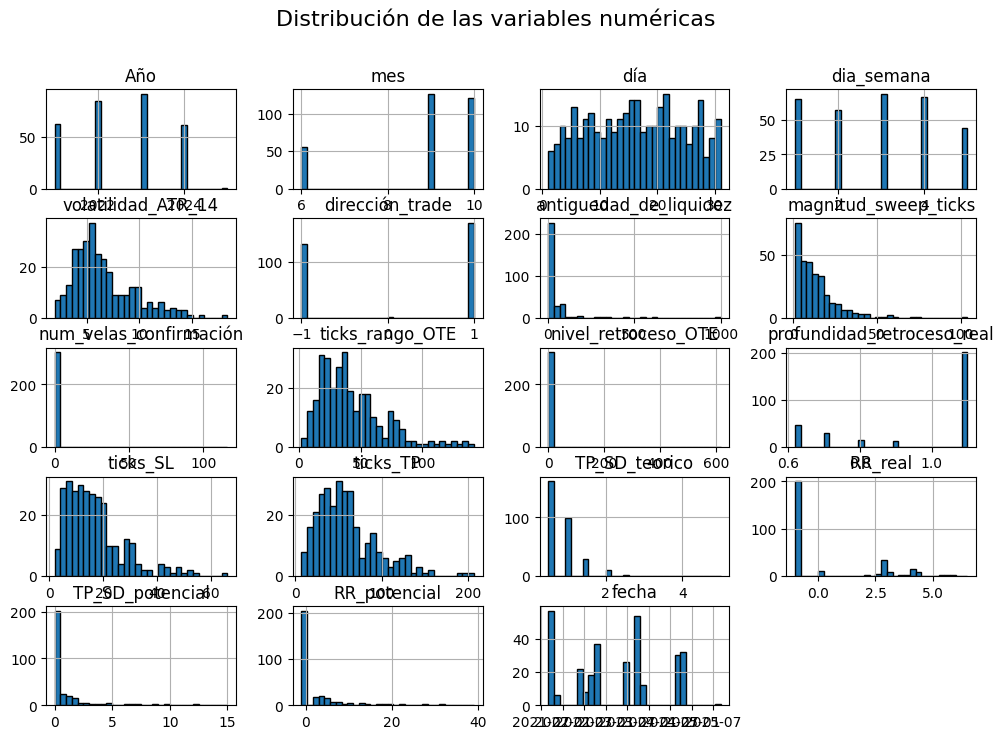

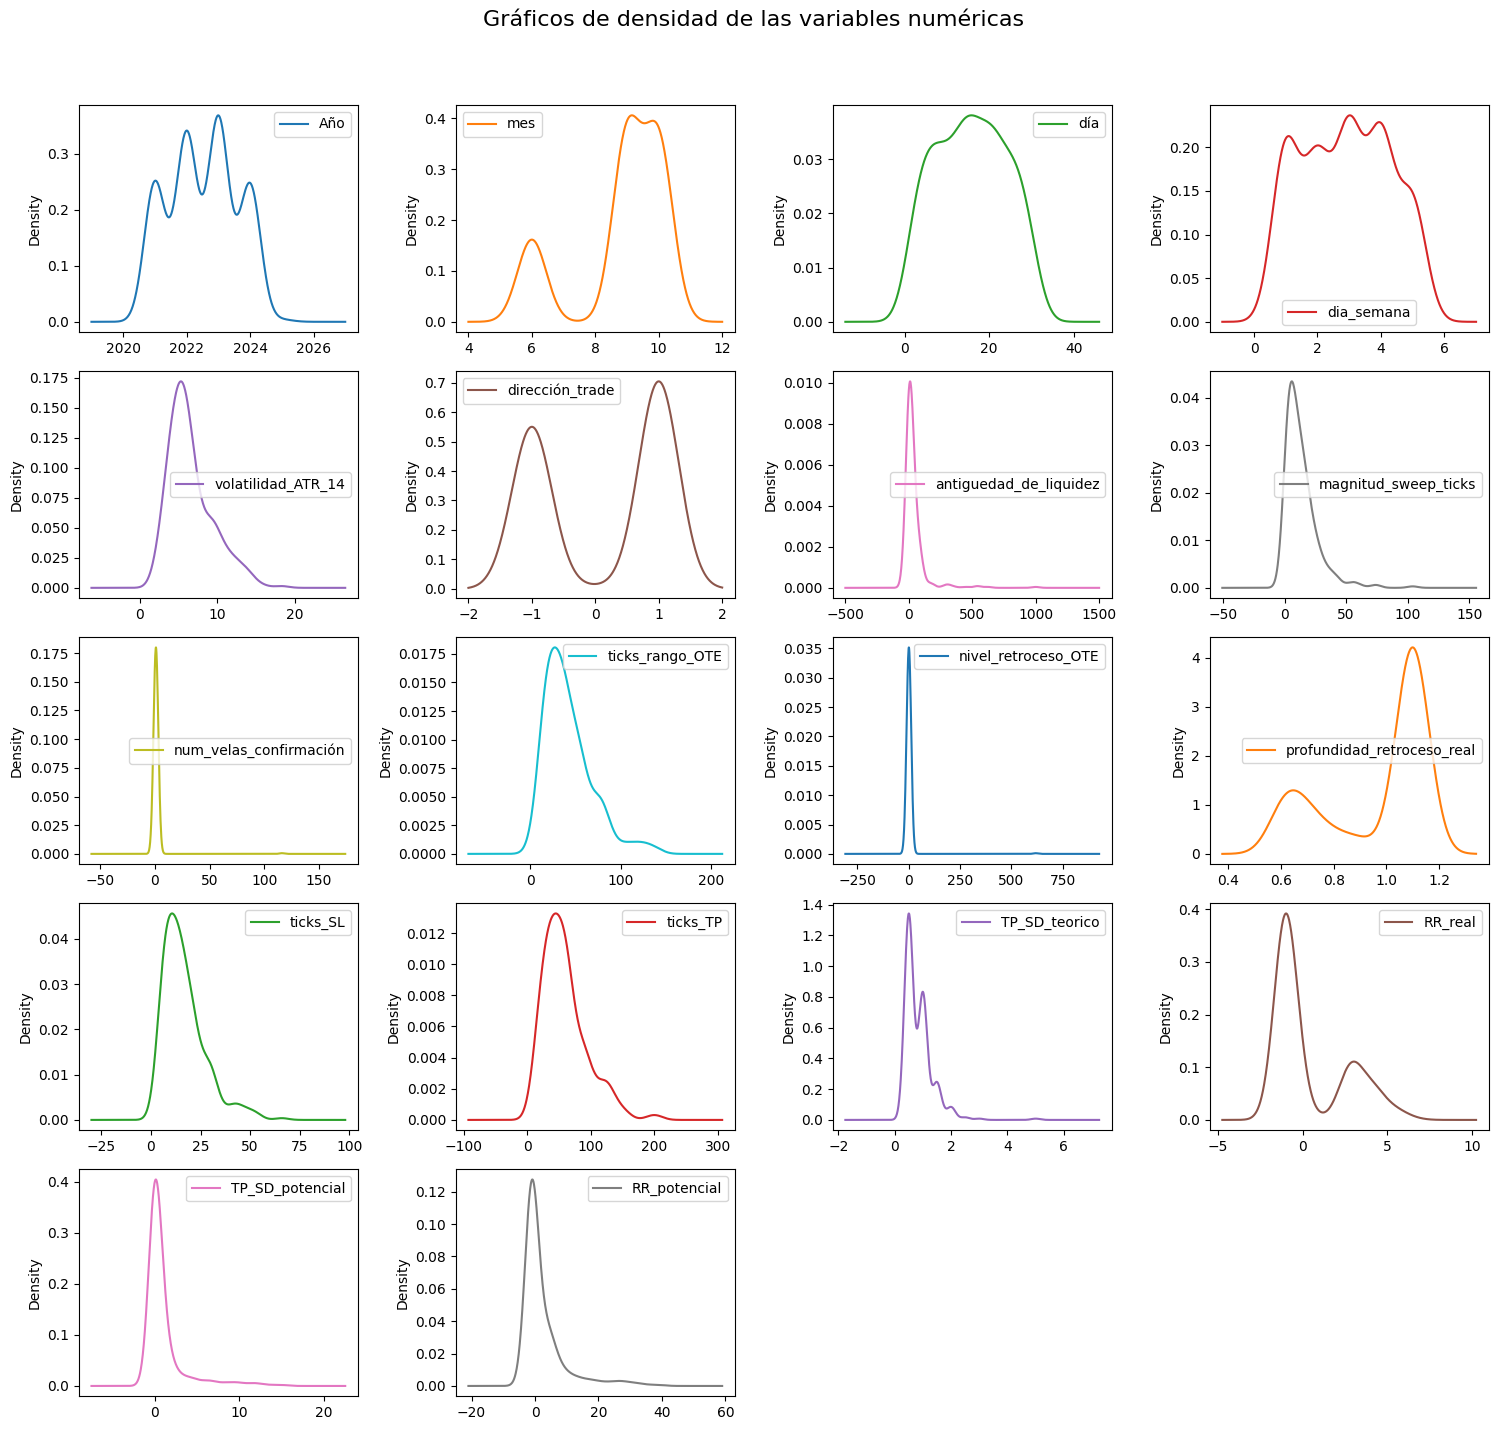

In [ ]:
# Histograma para visualizar la distribución de cada variable numérica
df.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Distribución de las variables numéricas", fontsize=16)
plt.show()

# Gráficos de densidad para una mejor visualización de la distribución
# Seleccionar solo columnas numéricas para el gráfico de densidad
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
df[numeric_cols].plot(kind='density', subplots=True, layout=(5, 4), figsize=(15, 15), sharex=False) # Adjusted layout to 5x4
plt.suptitle("Gráficos de densidad de las variables numéricas", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

In [ ]:
print(df['resultado'].unique())

['Take Profit' 'Stoploss' 'Break Even']


--- Analizando 'volatilidad_ATR_14' por intervalos ---


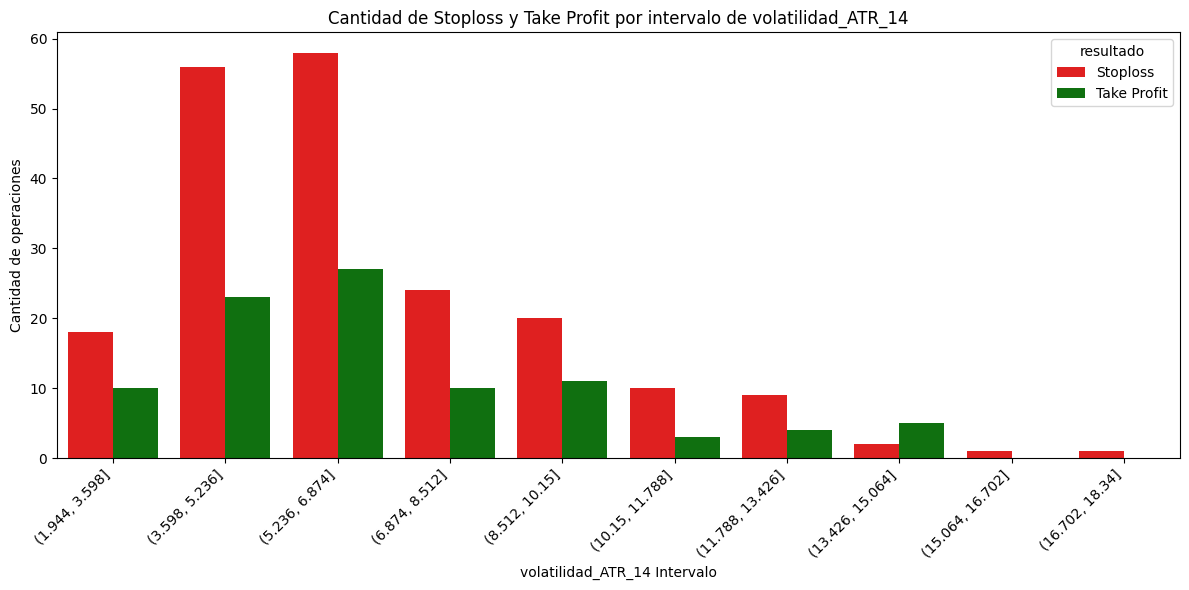


Win Rate por intervalo para 'volatilidad_ATR_14':


,Intervalo,Total Trades,Win Rate (%)
0,"(1.944, 3.598]",28,35.714286
6,"(3.598, 5.236]",79,29.113924
7,"(5.236, 6.874]",85,31.764706
8,"(6.874, 8.512]",34,29.411765
9,"(8.512, 10.15]",31,35.483871
1,"(10.15, 11.788]",13,23.076923
2,"(11.788, 13.426]",13,30.769231
3,"(13.426, 15.064]",7,71.428571
4,"(15.064, 16.702]",1,0.000000
5,"(16.702, 18.34]",1,0.000000


------------------------------
--- Analizando 'magnitud_sweep_ticks' por intervalos ---


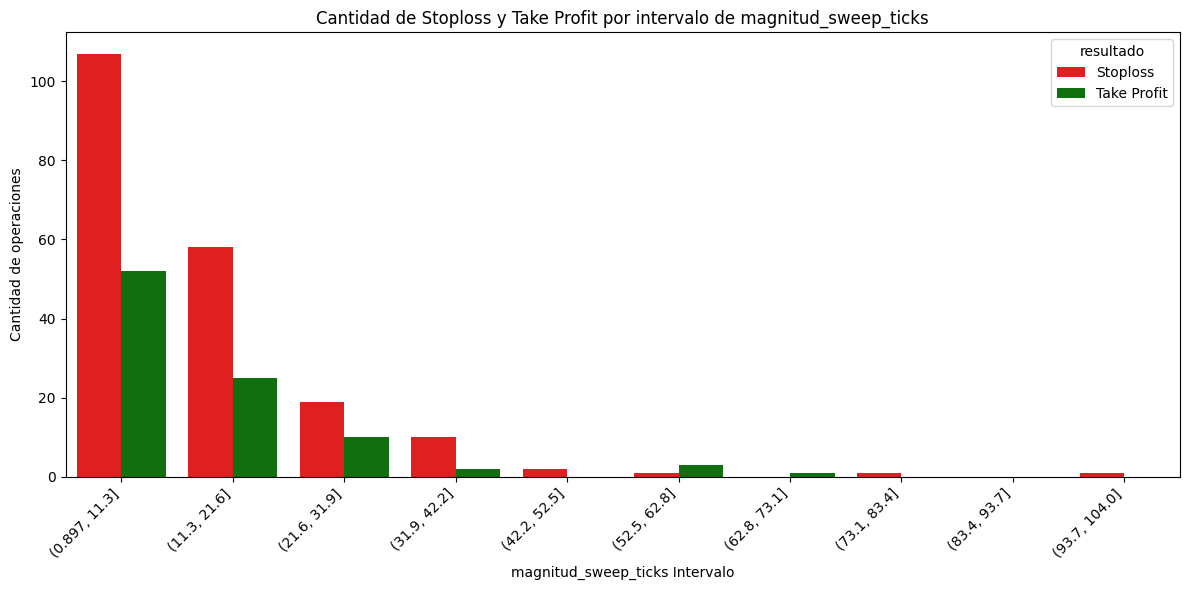


Win Rate por intervalo para 'magnitud_sweep_ticks':


,Intervalo,Total Trades,Win Rate (%)
0,"(0.897, 11.3]",159,32.704403
1,"(11.3, 21.6]",83,30.120482
2,"(21.6, 31.9]",29,34.482759
3,"(31.9, 42.2]",12,16.666667
4,"(42.2, 52.5]",2,0.000000
5,"(52.5, 62.8]",4,75.000000
6,"(62.8, 73.1]",1,100.000000
7,"(73.1, 83.4]",1,0.000000
8,"(93.7, 104.0]",1,0.000000


------------------------------
--- Analizando 'ticks_rango_OTE' por intervalos ---


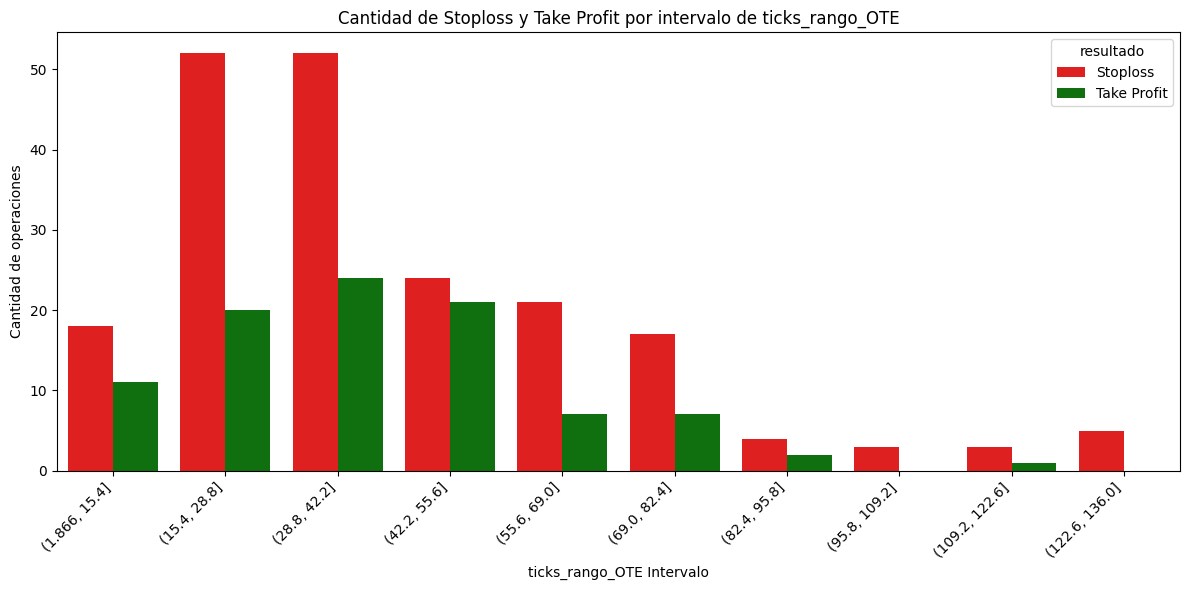


Win Rate por intervalo para 'ticks_rango_OTE':


,Intervalo,Total Trades,Win Rate (%)
0,"(1.866, 15.4]",29,37.931034
3,"(15.4, 28.8]",72,27.777778
4,"(28.8, 42.2]",76,31.578947
5,"(42.2, 55.6]",45,46.666667
6,"(55.6, 69.0]",28,25.000000
7,"(69.0, 82.4]",24,29.166667
8,"(82.4, 95.8]",6,33.333333
9,"(95.8, 109.2]",3,0.000000
1,"(109.2, 122.6]",4,25.000000
2,"(122.6, 136.0]",5,0.000000


------------------------------
--- Analizando 'antiguedad_de_liquidez' por intervalos ---


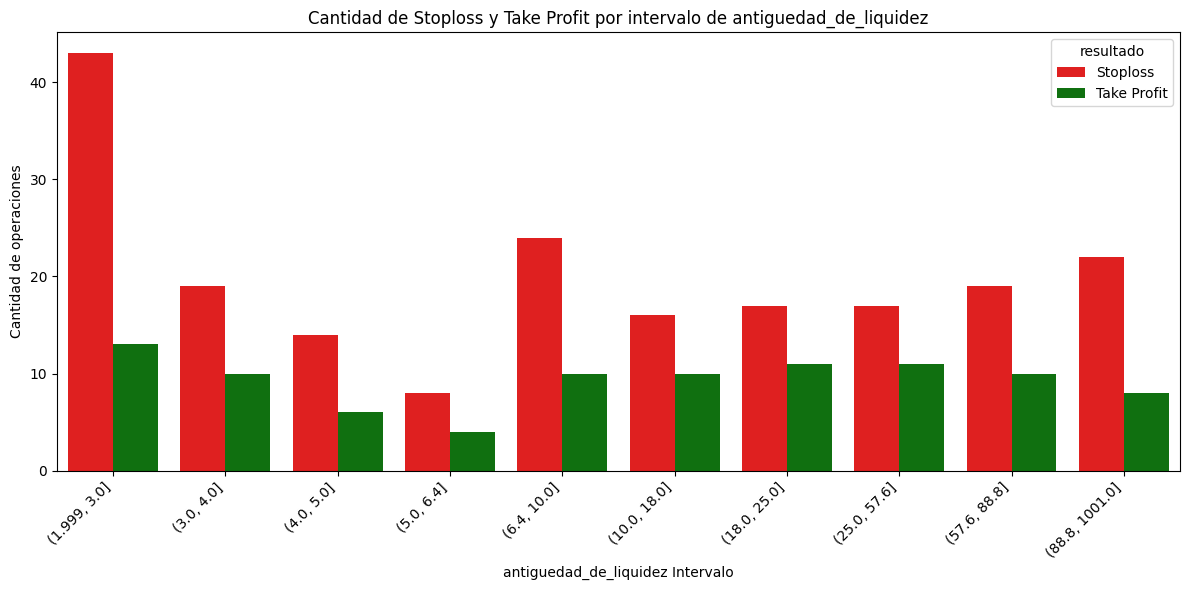


Win Rate por intervalo para 'antiguedad_de_liquidez':


,Intervalo,Total Trades,Win Rate (%)
0,"(1.999, 3.0]",56,23.214286
4,"(3.0, 4.0]",29,34.482759
5,"(4.0, 5.0]",20,30.000000
6,"(5.0, 6.4]",12,33.333333
8,"(6.4, 10.0]",34,29.411765
1,"(10.0, 18.0]",26,38.461538
2,"(18.0, 25.0]",28,39.285714
3,"(25.0, 57.6]",28,39.285714
7,"(57.6, 88.8]",29,34.482759
9,"(88.8, 1001.0]",30,26.666667


------------------------------
--- Analizando 'dia_semana' por intervalos ---


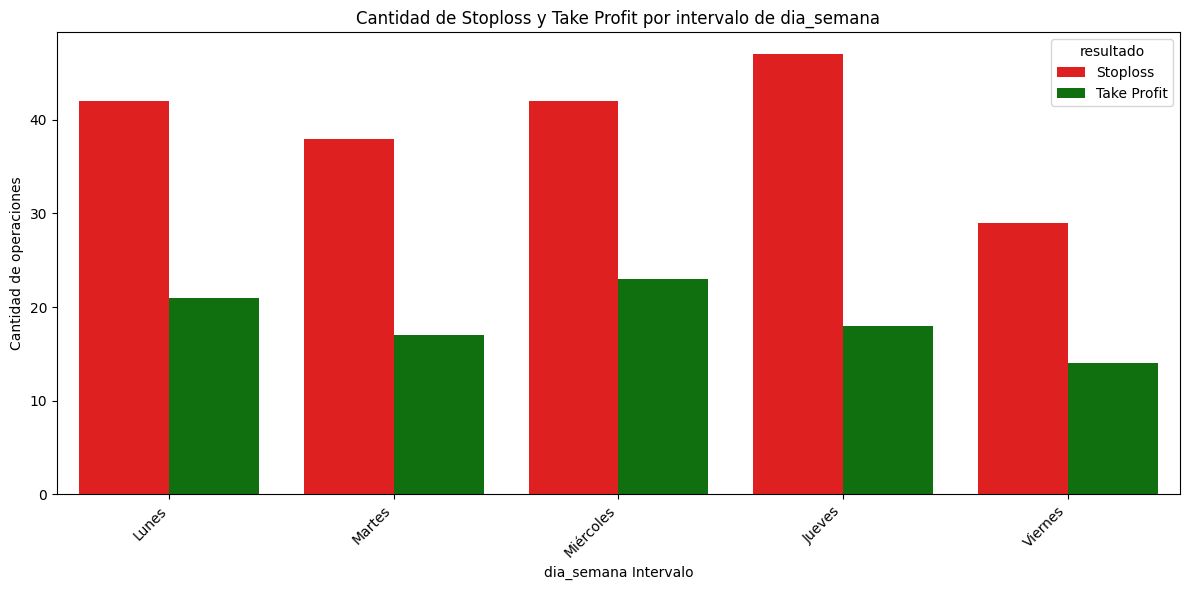


Win Rate por intervalo para 'dia_semana':


,Intervalo,Total Trades,Win Rate (%)
1,Lunes,63,33.333333
2,Martes,55,30.909091
3,Miércoles,65,35.384615
0,Jueves,65,27.692308
4,Viernes,43,32.558140
5,NaN,1,0.000000


------------------------------


In [ ]:
# Filter for 'Take Profit' and 'Stoploss' results
df_filtered = df[df['resultado'].isin(['Take Profit', 'Stoploss'])].copy()

# Define the numerical variables to analyze (excluding 'hora' for now due to data issues)
# Added 'dia_semana' as requested
variables_to_analyze = ['volatilidad_ATR_14', 'magnitud_sweep_ticks', 'ticks_rango_OTE', 'antiguedad_de_liquidez', 'dia_semana']

# Day names mapping for 'dia_semana'
day_names = {1: 'Lunes', 2: 'Martes', 3: 'Miércoles', 4: 'Jueves', 5: 'Viernes'}
day_order = list(day_names.values()) # Define the desired order for days

# Function to create grouped bar chart and calculate win rate per bin using Matplotlib/Seaborn
def analyze_variable_by_intervals(df, variable, bins=10):
    print(f"--- Analizando '{variable}' por intervalos ---")

    # Handle 'dia_semana' separately as it's not a continuous numerical variable for binning
    if variable == 'dia_semana':
        # Use day names for plotting and table
        df[f'{variable}_bin'] = df[variable].map(day_names).astype(str)
        # Drop rows where mapping resulted in NaN (if original dia_semana was NaN)
        df_binned = df.dropna(subset=[f'{variable}_bin']).copy()
        # Define the order for sorting days
        bin_order = day_order
    else:
        # Create bins for the numerical variable and convert to string immediately
        if variable == 'magnitud_sweep_ticks':
            # Using default bins for magnitud_sweep_ticks as requested previously
            original_bins = pd.cut(df[variable], bins=bins)
        elif variable == 'antiguedad_de_liquidez':
            # Use quantile-based binning for 'antiguedad_de_liquidez'
            original_bins = pd.qcut(df[variable], q=bins, duplicates='drop')
        else:
            original_bins = pd.cut(df[variable], bins=bins)

        df[f'{variable}_bin'] = original_bins.astype(str)
        # Drop rows where the binned variable resulted in NaN
        df_binned = df.dropna(subset=[f'{variable}_bin']).copy()
        # Define the order of bins based on the original intervals
        bin_order = [str(cat) for cat in original_bins.cat.categories if pd.notna(cat)]


    # Calculate counts of 'Take Profit' and 'Stoploss' per bin
    df_counts = df_binned.groupby([f'{variable}_bin', 'resultado']).size().reset_index(name='count')

    # Calculate total trades per bin
    df_total_trades = df_binned.groupby(f'{variable}_bin').size().reset_index(name='total_trades')

    # Merge counts with total trades
    df_merged = pd.merge(df_counts, df_total_trades, on=f'{variable}_bin')

    # Calculate win rate
    df_merged['win_rate'] = np.where(df_merged['resultado'] == 'Take Profit', (df_merged['count'] / df_merged['total_trades']) * 100, 0)


    # --- Plotting with Matplotlib/Seaborn ---
    plt.figure(figsize=(12, 6)) # Adjust figure size as needed
    # Use order parameter for sorting the x-axis
    sns.barplot(data=df_counts, x=f'{variable}_bin', y='count', hue='resultado', palette={'Take Profit': 'green', 'Stoploss': 'red'}, order=bin_order)
    plt.title(f'Cantidad de Stoploss y Take Profit por intervalo de {variable}')
    plt.xlabel(f'{variable} Intervalo')
    plt.ylabel('Cantidad de operaciones')
    plt.xticks(rotation=45, ha='right') # Rotate labels for better readability
    plt.tight_layout()
    plt.show()

    # --- Calculate and Print Win Rate per Category ---
    print(f"\nWin Rate por intervalo para '{variable}':")
    # Filter for 'Take Profit' results to get win rate per bin
    df_win_rate_per_bin = df_merged[df_merged['resultado'] == 'Take Profit'].copy()

    # Ensure all bins from total_trades are considered, even if TP count is 0
    win_rate_summary = pd.merge(df_total_trades, df_win_rate_per_bin[[f'{variable}_bin', 'win_rate']], on=f'{variable}_bin', how='left').fillna({'win_rate': 0.0})
    win_rate_summary = win_rate_summary.rename(columns={f'{variable}_bin': 'Intervalo', 'total_trades': 'Total Trades', 'win_rate': 'Win Rate (%)'})

    # Sort the table using the defined bin order
    win_rate_summary['Intervalo'] = pd.Categorical(win_rate_summary['Intervalo'], categories=bin_order, ordered=True)
    win_rate_summary = win_rate_summary.sort_values('Intervalo')


    # Display win rate for each bin
    if not win_rate_summary.empty:
        display(win_rate_summary[['Intervalo', 'Total Trades', 'Win Rate (%)']])
    else:
        print("No 'Take Profit' trades found in any interval.")

    print("-" * 30) # Separator for clarity

# Generate and display charts and win rates for each variable
for variable in variables_to_analyze:
    # Use df_filtered.copy() to ensure function works on a copy and doesn't modify original filtered df in the loop
    analyze_variable_by_intervals(df_filtered.copy(), variable, bins=10) # Pass bins=10 here


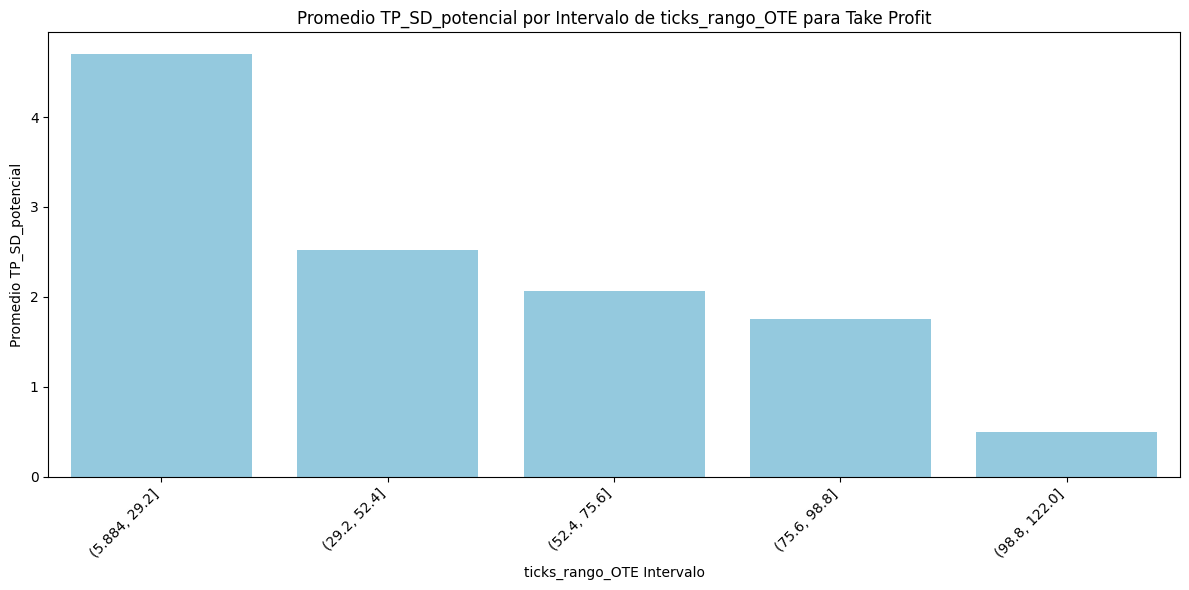

In [ ]:
# Ensure 'ticks_rango_OTE_interval' is created if not already
if 'ticks_rango_OTE_interval' not in df_tp:
    df_tp['ticks_rango_OTE_interval'] = pd.cut(df_tp['ticks_rango_OTE'], bins=5, duplicates='drop')

# Calculate the mean TP_SD_potencial for each interval
tp_sd_potential_mean_per_interval = df_tp.groupby('ticks_rango_OTE_interval')['TP_SD_potencial'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=tp_sd_potential_mean_per_interval, x='ticks_rango_OTE_interval', y='TP_SD_potencial', color='skyblue')
plt.title('Promedio TP_SD_potencial por Intervalo de ticks_rango_OTE para Take Profit')
plt.xlabel('ticks_rango_OTE Intervalo')
plt.ylabel('Promedio TP_SD_potencial')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
df_filtered = df[df['resultado'].isin(['Take Profit', 'Stoploss'])].copy()


df_filtered_ote = df_filtered[df_filtered['ticks_rango_OTE'] <= 55.2].copy()

# Calculate the number of Take Profit and Stoploss trades in the filtered data
total_trades_filtered = len(df_filtered_ote)
take_profit_count_filtered = df_filtered_ote[df_filtered_ote['resultado'] == 'Take Profit'].shape[0]
stoploss_count_filtered = df_filtered_ote[df_filtered_ote['resultado'] == 'Stoploss'].shape[0]

# Calculate the overall win rate for the filtered data
# Ensure total_trades_filtered is not zero to avoid division by zero
overall_win_rate_filtered = (take_profit_count_filtered / total_trades_filtered) * 100 if total_trades_filtered > 0 else 0

print(f"Número total de operaciones (TP y SL) con OTE <= 55.2: {total_trades_filtered}")
print(f"Número de operaciones con Take Profit con OTE <= 55.2: {take_profit_count_filtered}")
print(f"Número de operaciones con Stoploss con OTE <= 55.2: {stoploss_count_filtered}")
print(f"Win Rate general para operaciones con OTE <= 55.2: {overall_win_rate_filtered:.2f}%")


Número total de operaciones (TP y SL) con OTE <= 55.2: 222
Número de operaciones con Take Profit con OTE <= 55.2: 76
Número de operaciones con Stoploss con OTE <= 55.2: 146
Win Rate general para operaciones con OTE <= 55.2: 34.23%


En los gráfico se pudo visualizar que el winrate para las operaciones que tenían +55.2 ticks en el rango de OTE era muy bajo, eliminando esas se incrementa notoriamente el winrate, por eso pasamos a crear df_filtered_ote_new, que elimina las operaciones con más de 55 ticks de rango OTE y con +300 velas de atiguedad de liquidez.

In [ ]:
df_filtered = df[df['resultado'].isin(['Take Profit', 'Stoploss'])].copy()

variable = 'antiguedad_de_liquidez'

custom_bins = [0, 10, 50, 100, 200, 300, float('inf')]
labels = ['0-10', '10-50', '50-100', '100-200', '200-300', '+300']

df_filtered[f'{variable}_bin'] = pd.cut(df_filtered[variable], bins=custom_bins, labels=labels, right=False, include_lowest=True).astype(str)

df_counts = df_filtered.groupby([f'{variable}_bin', 'resultado']).size().reset_index(name='count')


df_total_trades = df_filtered.groupby(f'{variable}_bin').size().reset_index(name='total_trades')


df_merged = pd.merge(df_counts, df_total_trades, on=f'{variable}_bin')


df_merged['win_rate'] = np.where(df_merged['resultado'] == 'Take Profit', (df_merged['count'] / df_merged['total_trades']) * 100, 0)


df_win_rate = df_merged[df_merged['resultado'] == 'Take Profit'].copy()

all_bins_df = pd.DataFrame({f'{variable}_bin': labels})

df_win_rate = pd.merge(all_bins_df, df_win_rate, on=f'{variable}_bin', how='left').fillna({'count': 0, 'total_trades': 0, 'win_rate': 0.0})

df_win_rate = df_win_rate[[f'{variable}_bin', 'count', 'total_trades', 'win_rate']]
df_win_rate.rename(columns={f'{variable}_bin': f'{variable} Intervalo', 'count': 'Take Profit Count', 'total_trades': 'Total Trades'}, inplace=True)

interval_cat_type = pd.CategoricalDtype(categories=labels, ordered=True)
df_win_rate[f'{variable} Intervalo'] = df_win_rate[f'{variable} Intervalo'].astype(interval_cat_type)
df_win_rate = df_win_rate.sort_values(f'{variable} Intervalo')


# Display the table
display(df_win_rate)

,antiguedad_de_liquidez Intervalo,Take Profit Count,Total Trades,win_rate
0,0-10,42.0,144.0,29.166667
1,10-50,29.0,82.0,35.365854
2,50-100,19.0,49.0,38.775510
3,100-200,2.0,7.0,28.571429
4,200-300,0.0,0.0,0.000000
5,+300,1.0,9.0,11.111111


In [ ]:
df_filtered_ote_new = df[(df['ticks_rango_OTE'] <= 55.2) & (df['antiguedad_de_liquidez'] <= 300)].copy()
display(df_filtered_ote_new.head())

,Año,mes,día,dia_semana,hora,volatilidad_ATR_14,dirección_trade,tipo_de_liquidez_tomada,antiguedad_de_liquidez,magnitud_sweep_ticks,...,nivel_retroceso_OTE,profundidad_retroceso_real,ticks_SL,ticks_TP,TP_SD_teorico,RR_real,TP_SD_potencial,RR_potencial,resultado,fecha
0,2021,9,1,3,08:00:00,1.96,-1.0,H/L,4,4,...,0.618,0.618,5,19,1.0,3.80,5.5,14.60,Take Profit,2021-09-01
1,2021,9,1,3,09:45:00,3.22,1.0,H/L,52,8,...,0.618,0.705,11,29,0.5,2.64,0.5,2.64,Take Profit,2021-09-01
2,2021,9,2,4,09:00:00,1.99,-1.0,H/L,74,2,...,1.100,1.100,4,12,0.5,-1.00,0.0,-1.00,Stoploss,2021-09-02
3,2021,9,2,4,09:30:00,2.29,-1.0,Equal H/L,115,16,...,0.618,0.618,13,35,0.5,2.69,1.5,5.15,Take Profit,2021-09-02
5,2021,9,8,3,09:30:00,3.95,1.0,H/L + FVG,4,18,...,1.100,1.100,12,34,0.5,-1.00,0.0,-1.00,Stoploss,2021-09-08


In [ ]:
df_filtered_ote_new_tp = df_filtered_ote_new[df_filtered_ote_new['resultado'] == 'Take Profit'].copy()
display(df_filtered_ote_new_tp.describe(percentiles=[.1,.25, .5, .75, .90]))

,Año,mes,día,dia_semana,volatilidad_ATR_14,dirección_trade,antiguedad_de_liquidez,magnitud_sweep_ticks,num_velas_confirmación,ticks_rango_OTE,nivel_retroceso_OTE,profundidad_retroceso_real,ticks_SL,ticks_TP,TP_SD_teorico,RR_real,TP_SD_potencial,RR_potencial,fecha
count,75.0,75.0,75.0,75.0,75.000000,75.000000,75.0,75.0,75.0,75.0,75.000000,75.000000,75.0,75.0,75.000000,75.000000,75.000000,75.000000,75
mean,2022.506667,8.84,15.08,2.693333,6.086000,-0.080000,27.426667,11.746667,0.946667,31.56,8.857347,0.708053,12.253333,43.746667,0.806667,3.553733,3.506667,10.403067,2023-03-14 00:00:00
min,2021.0,6.0,1.0,1.0,1.960000,-1.000000,2.0,1.0,0.0,6.0,0.618000,0.618000,2.0,7.0,0.500000,-1.000000,0.000000,-1.000000,2021-09-01 00:00:00
10%,2021.0,6.0,4.4,1.0,3.288000,-1.000000,3.0,2.0,0.0,14.4,0.618000,0.618000,6.0,18.4,0.500000,2.690000,0.500000,2.876000,2021-10-12 14:24:00
25%,2022.0,9.0,8.0,1.0,4.245000,-1.000000,4.0,3.5,1.0,20.0,0.618000,0.618000,8.0,29.0,0.500000,2.830000,1.000000,4.120000,2022-06-22 12:00:00
50%,2023.0,9.0,15.0,3.0,5.560000,-1.000000,10.0,8.0,1.0,31.0,0.618000,0.705000,12.0,42.0,0.500000,3.000000,1.500000,5.860000,2023-06-06 00:00:00
75%,2023.0,10.0,21.0,4.0,7.025000,1.000000,41.0,17.0,1.0,43.0,0.618000,0.800000,17.0,56.0,1.000000,4.210000,5.250000,14.635000,2023-10-13 12:00:00
90%,2024.0,10.0,25.6,5.0,9.860000,1.000000,74.6,25.0,1.6,50.0,0.618000,0.900000,19.0,67.8,1.500000,5.250000,9.500000,25.940000,2024-09-19 04:48:00
max,2024.0,10.0,31.0,5.0,14.440000,1.000000,162.0,73.0,2.0,55.0,618.000000,1.100000,21.0,105.0,2.000000,6.500000,15.000000,39.000000,2024-10-16 00:00:00
std,0.949727,1.44297,8.040035,1.404369,2.749673,0.996751,33.665755,12.267396,0.517095,13.528988,71.288267,0.106389,5.07536,20.519005,0.384614,1.149756,3.694859,9.278303,NaN


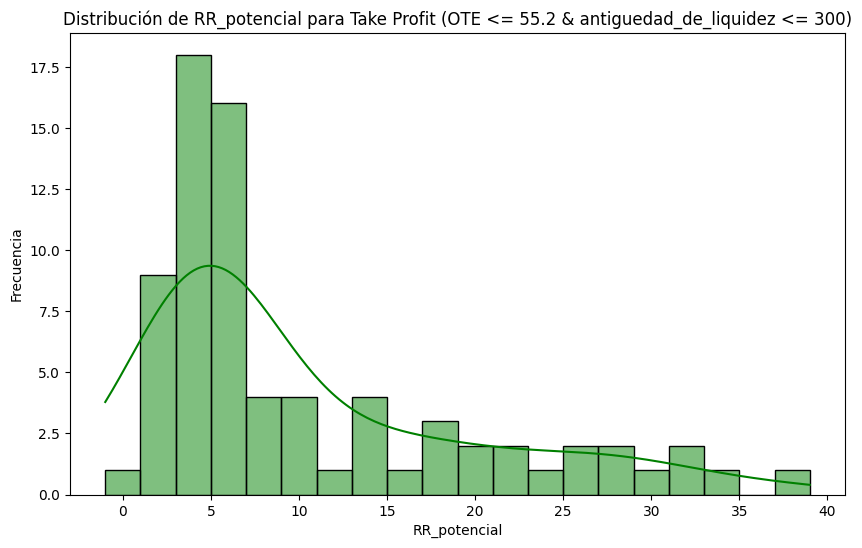

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered_ote_new_tp['RR_potencial'], bins=20, kde=True, color='green')
plt.title('Distribución de RR_potencial para Take Profit (OTE <= 55.2 & antiguedad_de_liquidez <= 300)')
plt.xlabel('RR_potencial')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Calculate the number of Take Profit and Stoploss trades in the filtered data
total_trades_filtered_new = len(df_filtered_ote_new)
take_profit_count_filtered_new = df_filtered_ote_new[df_filtered_ote_new['resultado'] == 'Take Profit'].shape[0]
stoploss_count_filtered_new = df_filtered_ote_new[df_filtered_ote_new['resultado'] == 'Stoploss'].shape[0]

# Calculate the overall win rate for the filtered data
# Ensure total_trades_filtered_new is not zero to avoid division by zero
overall_win_rate_filtered_new = (take_profit_count_filtered_new / total_trades_filtered_new) * 100 if total_trades_filtered_new > 0 else 0

print(f"Número total de operaciones (TP y SL) con OTE <= 55.2 y antiguedad_de_liquidez <= 300: {total_trades_filtered_new}")
print(f"Número de operaciones con Take Profit con OTE <= 55.2 y antiguedad_de_liquidez <= 300: {take_profit_count_filtered_new}")
print(f"Número de operaciones con Stoploss con OTE <= 55.2 y antiguedad_de_liquidez <= 300: {stoploss_count_filtered_new}")
print(f"Win Rate general para operaciones con OTE <= 55.2 y antiguedad_de_liquidez <= 300: {overall_win_rate_filtered_new:.2f}%")

Número total de operaciones (TP y SL) con OTE <= 55.2 y antiguedad_de_liquidez <= 300: 223
Número de operaciones con Take Profit con OTE <= 55.2 y antiguedad_de_liquidez <= 300: 75
Número de operaciones con Stoploss con OTE <= 55.2 y antiguedad_de_liquidez <= 300: 140
Win Rate general para operaciones con OTE <= 55.2 y antiguedad_de_liquidez <= 300: 33.63%


# Métricas del modelo limpio

In [ ]:
df_filtered_results = df_filtered_ote_new[df_filtered_ote_new['resultado'].isin(['Take Profit', 'Stoploss'])].copy()

# Calculo Win Rate
total_trades = len(df_filtered_results)
take_profit_trades = df_filtered_results[df_filtered_results['resultado'] == 'Take Profit'].shape[0]
win_rate = (take_profit_trades / total_trades) * 100 if total_trades > 0 else 0

# Calculo max losses
losses_only = df_filtered_results['resultado'].apply(lambda x: 1 if x == 'Stoploss' else 0)
max_consecutive_losses = 0
current_consecutive_losses = 0
for loss in losses_only:
    if loss == 1:
        current_consecutive_losses += 1
    else:
        max_consecutive_losses = max(max_consecutive_losses, current_consecutive_losses)
        current_consecutive_losses = 0
# Check one last time after the loop in case the data ends with losses
max_consecutive_losses = max(max_consecutive_losses, current_consecutive_losses)


average_rr_potential_tp = df_filtered_ote_new_tp['RR_potencial'].sum() / len(df_filtered_ote_new_tp)
average_rr_real_tp = df_filtered_ote_new_tp['RR_real'].sum() / len(df_filtered_ote_new_tp)

print(f"El promedio de RR_potencial para los Take Profit: {average_rr_potential_tp:.2f}")
print(f"El promedio de RR_real para los Take Profit: {average_rr_real_tp:.2f}")


# Print the results
print(f"Win Rate: {win_rate:.2f}%")
print(f"Maximum Consecutive Losses: {max_consecutive_losses}")

El promedio de RR_potencial para los Take Profit: 10.40
El promedio de RR_real para los Take Profit: 3.55
Win Rate: 34.88%
Maximum Consecutive Losses: 13


# Optimización TP

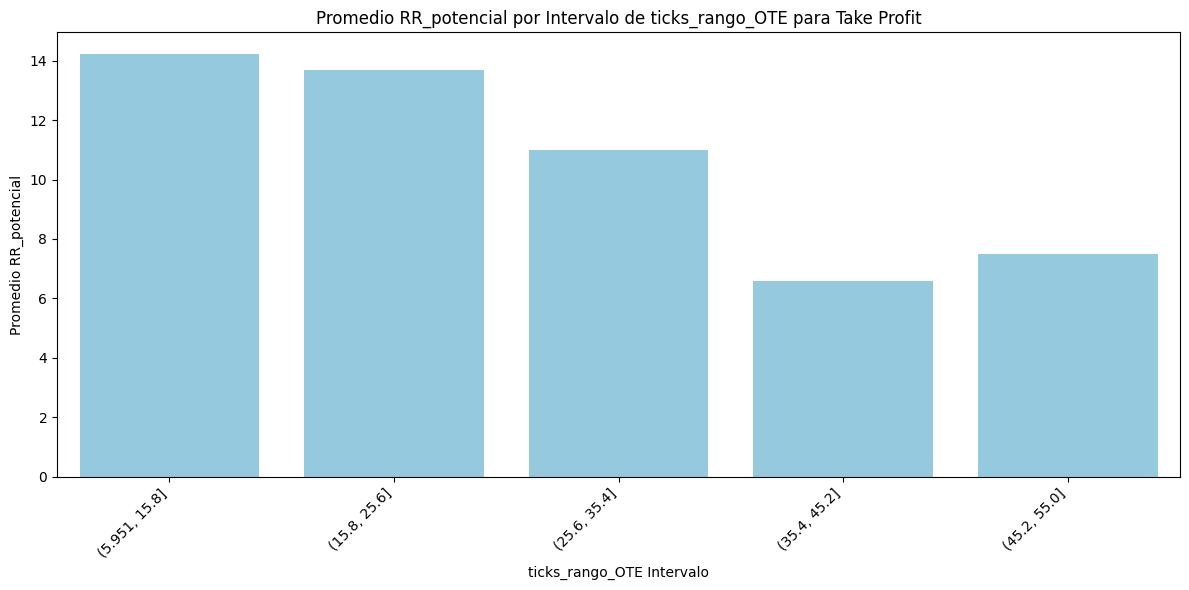

In [ ]:
# Create intervals for 'ticks_rango_OTE'
df_filtered_ote_new_tp['intervalo_ticks_rango_OTE'] = pd.cut(df_filtered_ote_new_tp['ticks_rango_OTE'], bins=5, duplicates='drop')

# Calculate the mean RR_potencial for each interval
rr_potential_mean_per_interval = df_filtered_ote_new_tp.groupby('intervalo_ticks_rango_OTE')['RR_potencial'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=rr_potential_mean_per_interval, x='intervalo_ticks_rango_OTE', y='RR_potencial', color='skyblue')
plt.title('Promedio RR_potencial por Intervalo de ticks_rango_OTE para Take Profit')
plt.xlabel('ticks_rango_OTE Intervalo')
plt.ylabel('Promedio RR_potencial')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

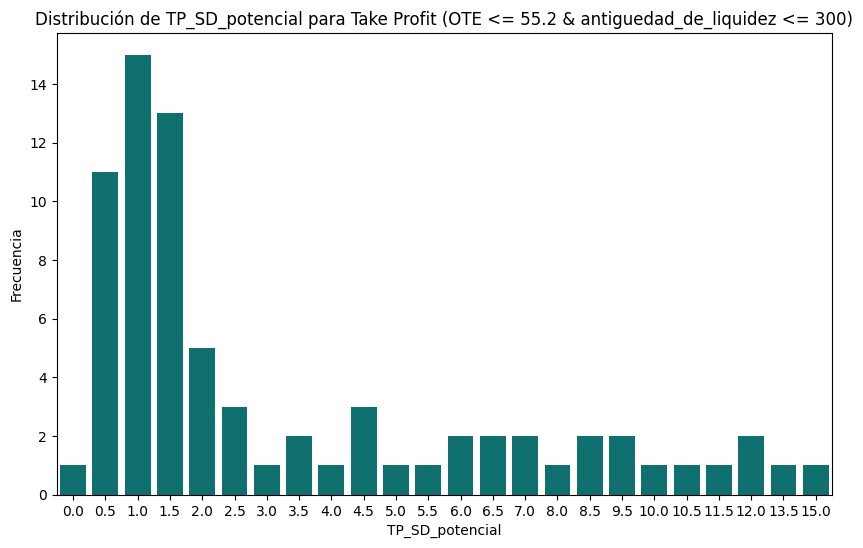

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered_ote_new_tp, x='TP_SD_potencial', color='teal')
plt.title('Distribución de TP_SD_potencial para Take Profit (OTE <= 55.2 & antiguedad_de_liquidez <= 300)')
plt.xlabel('TP_SD_potencial')
plt.ylabel('Frecuencia')
plt.show()

A continuacion describimos los percentiles de el RR potencial por intervalo de rango OTE.

In [ ]:
# Create intervals for 'ticks_rango_OTE' with 10 bins
ote_bins = pd.cut(df_filtered_ote_new_tp['ticks_rango_OTE'], bins=7, duplicates='drop')
df_filtered_ote_new_tp['ticks_rango_OTE_interval'] = ote_bins

# Calculate descriptive statistics for RR_potencial by OTE interval
rr_potential_stats = df_filtered_ote_new_tp.groupby('ticks_rango_OTE_interval')['RR_potencial'].describe(percentiles=[.1,.25, .5, .75, .90])

# Create a DataFrame with all possible bins to ensure all intervals are displayed
all_bins = pd.DataFrame({'ticks_rango_OTE_interval': ote_bins.cat.categories})

# Merge the descriptive statistics with the all_bins DataFrame to include intervals with no data
rr_potential_stats_complete = pd.merge(all_bins, rr_potential_stats, on='ticks_rango_OTE_interval', how='left')

display(rr_potential_stats_complete)

,ticks_rango_OTE_interval,count,mean,std,min,10%,25%,50%,75%,90%,max
0,"(5.951, 13.0]",7.0,12.992857,10.483973,2.40,2.760,4.9000,10.000,20.5000,26.940,27.75
1,"(13.0, 20.0]",14.0,16.500714,12.096148,2.83,4.001,5.8950,15.445,25.0200,31.500,39.00
2,"(20.0, 27.0]",8.0,10.425000,11.090824,2.64,3.515,3.9725,4.995,11.5725,27.885,29.25
3,"(27.0, 34.0]",14.0,10.854286,9.263445,2.75,2.881,5.1900,6.910,15.0800,21.130,34.77
4,"(34.0, 41.0]",11.0,7.397273,6.277761,2.86,4.070,4.2100,4.710,6.1200,17.000,22.40
5,"(41.0, 48.0]",9.0,6.454444,3.365762,2.94,3.836,4.2900,5.560,8.0600,10.534,13.39
6,"(48.0, 55.0]",12.0,6.954167,5.990296,-1.00,2.846,2.9750,4.775,9.3450,14.478,20.00


A continuación describimos los percentiles de la SD potencial a la que se llega por intervalo de rango OTE.

In [ ]:
# Create intervals for 'ticks_rango_OTE' with 10 bins for df_filtered_ote_new_tp
ote_bins_tp = pd.cut(df_filtered_ote_new_tp['ticks_rango_OTE'], bins=7, duplicates='drop')
df_filtered_ote_new_tp['ticks_rango_OTE_interval'] = ote_bins_tp

# Calculate descriptive statistics for TP_SD_potencial by OTE interval
tp_sd_potential_stats = df_filtered_ote_new_tp.groupby('ticks_rango_OTE_interval')['TP_SD_potencial'].describe(percentiles=[.1,.25, .5, .75, .90])

# Create a DataFrame with all possible bins to ensure all intervals are displayed
all_bins_tp = pd.DataFrame({'ticks_rango_OTE_interval': ote_bins_tp.cat.categories})

# Merge the descriptive statistics with the all_bins DataFrame to include intervals with no data
tp_sd_potential_stats_complete = pd.merge(all_bins_tp, tp_sd_potential_stats, on='ticks_rango_OTE_interval', how='left')

display(tp_sd_potential_stats_complete)

,ticks_rango_OTE_interval,count,mean,std,min,10%,25%,50%,75%,90%,max
0,"(5.951, 13.0]",7.0,5.000000,4.453463,0.5,0.80,1.500,4.00,8.000,10.90,11.5
1,"(13.0, 20.0]",14.0,5.892857,4.856315,0.5,1.00,1.625,5.50,9.250,12.00,15.0
2,"(20.0, 27.0]",8.0,3.312500,3.999442,0.5,0.85,1.000,1.25,3.875,9.65,10.0
3,"(27.0, 34.0]",14.0,3.678571,3.744777,0.5,0.50,1.500,2.00,5.375,7.70,13.5
4,"(34.0, 41.0]",11.0,2.318182,2.532516,0.5,1.00,1.000,1.50,1.750,6.00,8.5
5,"(41.0, 48.0]",9.0,1.833333,1.274755,0.5,0.90,1.000,1.50,2.500,3.30,4.5
6,"(48.0, 55.0]",12.0,2.125000,2.206653,0.0,0.50,0.500,1.25,3.000,4.95,7.0


## Grid Search de TP

In [ ]:

# -------------------------------------------------------------------
# Utilidades
# -------------------------------------------------------------------

def _interp_F_from_percentiles(R_candidates, px_pairs):
    """
    Interpola F(R) (CDF) de forma lineal a partir de pares (R_p, p) de percentiles.
    px_pairs: lista de tuplas (R_p, p) por ejemplo [(p10,0.10),(p25,0.25),(p50,0.50),(p75,0.75),(p90,0.90)]
    Retorna F(R) para cada R en R_candidates.
    """
    # Ordenar por R por seguridad y filtrar NaN
    clean = [(r, p) for (r, p) in px_pairs if pd.notna(r)]
    clean.sort(key=lambda t: t[0])
    if len(clean) < 2:
        return np.full_like(R_candidates, np.nan, dtype=float)

    Rp = np.array([t[0] for t in clean], dtype=float)
    pp = np.array([t[1] for t in clean], dtype=float)

    # Extrapolación suave: antes del mínimo usa el p mínimo, después del máximo usa el p máximo
    F_vals = np.interp(R_candidates, Rp, pp, left=pp[0], right=pp[-1])
    return F_vals

def _grid_between(p10, p90, step=0.25):
    """Arma una grilla de R entre p10 y p90 (incluye bordes). Si falta alguno, ajusta."""
    # Si falta p10/p90 por NaN, devolvemos None para marcar que no se puede optimizar ese bucket
    if pd.isna(p10) or pd.isna(p90):
        return None
    a, b = float(p10), float(p90)
    if b <= a:
        return None
    n = int(np.floor((b - a) / step)) + 1
    return np.round(np.linspace(a, b, n), 4)

# -------------------------------------------------------------------
# Cálculo del TP óptimo por bucket de OTE usando TUS percentiles
#   E_cond(R) = R * S(R) = R * (1 - F(R))
# -------------------------------------------------------------------

def find_optimal_tp_from_percentiles(rr_stats_complete: pd.DataFrame,
                                     col_interval='ticks_rango_OTE_interval',
                                     step=0.25):
    """
    Espera un DataFrame con columnas tipo describe():
      ['count','mean','std','min','10%','25%','50%','75%','90%','max']
    agrupadas por 'ticks_rango_OTE_interval'.
    Devuelve un DataFrame con el TP óptimo y métricas por bucket.
    """

    required_cols = {'10%', '25%', '50%', '75%', '90%'}
    missing = required_cols - set(rr_stats_complete.columns)
    if missing:
        raise ValueError(f"Faltan columnas de percentiles: {missing}")

    rows = []
    for _, row in rr_stats_complete.iterrows():
        bucket = row[col_interval]

        p10 = row['10%']
        p25 = row['25%']
        p50 = row['50%']
        p75 = row['75%']
        p90 = row['90%']

        grid = _grid_between(p10, p90, step=step)
        if grid is None or len(grid) == 0:
            rows.append({
                'ticks_rango_OTE_interval': bucket,
                'tp_optimo_R': np.nan,
                'E_cond_optimo_R': np.nan,
                'hit_prob_en_optimo': np.nan,
                'nota': 'Insuficiente rango (p10/p90) para optimizar'
            })
            continue

        # Construye pares (R_p, p) para la CDF F(R)
        px_pairs = [
            (row.get('10%', np.nan), 0.10),
            (row.get('25%', np.nan), 0.25),
            (row.get('50%', np.nan), 0.50),
            (row.get('75%', np.nan), 0.75),
            (row.get('90%', np.nan), 0.90),
        ]

        F_grid = _interp_F_from_percentiles(grid, px_pairs)  # CDF
        if np.all(np.isnan(F_grid)):
            rows.append({
                'ticks_rango_OTE_interval': bucket,
                'tp_optimo_R': np.nan,
                'E_cond_optimo_R': np.nan,
                'hit_prob_en_optimo': np.nan,
                'nota': 'No se pudo interpolar F(R)'
            })
            continue

        S_grid = 1.0 - F_grid  # Supervivencia ~ Prob de tocar al menos R (condicional a no-SL)
        E_cond_grid = grid * S_grid

        # Elegimos el máximo; si hay empate, preferimos el menor R (más robusto)
        max_E = np.nanmax(E_cond_grid)
        if np.isnan(max_E):
            rows.append({
                'ticks_rango_OTE_interval': bucket,
                'tp_optimo_R': np.nan,
                'E_cond_optimo_R': np.nan,
                'hit_prob_en_optimo': np.nan,
                'nota': 'E_cond indeterminado'
            })
            continue

        # índices que alcanzan el máximo (plateau)
        idx_max = np.where(np.isclose(E_cond_grid, max_E, rtol=1e-6, atol=1e-8))[0]
        # política: elegir el TP más bajo del plateau por robustez
        i = int(idx_max.min())

        rows.append({
            'ticks_rango_OTE_interval': bucket,
            'tp_optimo_R': float(grid[i]),
            'E_cond_optimo_R': float(E_cond_grid[i]),
            'hit_prob_en_optimo': float(S_grid[i]),
            'nota': ''
        })

    return pd.DataFrame(rows)

# -------------------------------------------------------------------
# USO: aplicar sobre tu rr_potential_stats_complete que ya generaste
# -------------------------------------------------------------------

tp_opt_por_bucket = find_optimal_tp_from_percentiles(rr_potential_stats_complete,
                                                     col_interval='ticks_rango_OTE_interval',
                                                     step=0.25)

display(tp_opt_por_bucket.sort_values('ticks_rango_OTE_interval'))


,ticks_rango_OTE_interval,tp_optimo_R,E_cond_optimo_R,hit_prob_en_optimo,nota
0,"(5.951, 13.0]",15.6056,5.719973,0.366533,
1,"(13.0, 20.0]",17.3721,7.811957,0.449684,
2,"(20.0, 27.0]",19.3429,3.453637,0.178548,
3,"(27.0, 34.0]",11.4986,4.134781,0.359590,
4,"(34.0, 41.0]",4.0700,3.663000,0.900000,
5,"(41.0, 48.0]",3.8360,3.452400,0.900000,
6,"(48.0, 55.0]",6.8919,2.647839,0.384196,


In [ ]:
# --- 1) Alinear tipos y mergear el TP óptimo por intervalo ---
left_key = 'ticks_rango_OTE_interval'
right_key = 'ticks_rango_OTE_interval'

# Si alguno de los dos tiene dtype 'category', alineamos categorías para evitar errores de merge
if pd.api.types.is_categorical_dtype(df_filtered_ote_new_tp[left_key]) and pd.api.types.is_categorical_dtype(tp_opt_por_bucket[right_key]):
    # Unificamos categorías (unión) para que el merge no falle
    cats = df_filtered_ote_new_tp[left_key].cat.categories.union(tp_opt_por_bucket[right_key].cat.categories)
    df_filtered_ote_new_tp[left_key] = df_filtered_ote_new_tp[left_key].cat.set_categories(cats)
    tp_opt_por_bucket[right_key] = tp_opt_por_bucket[right_key].cat.set_categories(cats)
else:
    # Fallback robusto: convertir ambos a string para mergear sin dramas de dtype
    df_filtered_ote_new_tp[left_key] = df_filtered_ote_new_tp[left_key].astype(str)
    tp_opt_por_bucket[right_key] = tp_opt_por_bucket[right_key].astype(str)

df_with_tp = df_filtered_ote_new_tp.merge(
    tp_opt_por_bucket[[right_key, 'tp_optimo_R']],
    left_on=left_key, right_on=right_key, how='left'
)

# --- 2) Crear la columna TP_optimo_result con la lógica solicitada ---
def _tp_optimo_result(row):
    rr_real = row.get('RR_real', np.nan)
    rr_pot  = row.get('RR_potencial', np.nan)
    tp_opt  = row.get('tp_optimo_R', np.nan)

    # Trades que fueron -1 en tus resultados reales se mantienen en -1
    if pd.notna(rr_real) and rr_real == -1:
        return -1.0

    # Si no hay TP óptimo disponible para ese bucket, poné NaN (o 0 si preferís)
    if pd.isna(tp_opt) or pd.isna(rr_pot):
        return np.nan

    # Si el RR potencial no alcanza el TP óptimo => BE (0)
    if rr_pot < tp_opt:
        return 0.0

    # Si alcanza o supera, capturás ese TP fijo
    return float(tp_opt)

df_with_tp['TP_optimo_result'] = df_with_tp.apply(_tp_optimo_result, axis=1)

# --- 3) Resúmenes útiles ---

# Suma total de TP_optimo_result (captura agregada en R)
tp_opt_total = df_with_tp['TP_optimo_result'].sum(min_count=1)

# Métricas por intervalo
metrics_por_intervalo = (
    df_with_tp
    .groupby('ticks_rango_OTE_interval', dropna=False)
    .agg(
        n_trades=('TP_optimo_result', 'size'),
        tp_opt_suma_R=('TP_optimo_result', lambda s: s.sum(min_count=1)),
        tp_opt_prom_R=('TP_optimo_result', 'mean'),
        hit_rate_TP=('TP_optimo_result', lambda s: np.mean(s > 0) if len(s) else np.nan),  # % que tocó TP
        pct_BE=('TP_optimo_result', lambda s: np.mean(s == 0) if len(s) else np.nan),
        pct_SL_menos1=('TP_optimo_result', lambda s: np.mean(s == -1) if len(s) else np.nan),
        rr_pot_mediana=('RR_potencial', 'median'),
        tp_opt_R=('tp_optimo_R', 'first')
    )
    .reset_index()
)

# (Opcional) Ordenar intervalos si quedaron como string con el patrón "(a, b]"
# Si querés reordenar por el límite inferior:
def _lower_bound_from_interval_str(s):
    # intenta extraer el primer número del string tipo "(6.0, 13.0]"
    try:
        return float(str(s).split(',')[0].strip('([ ]'))
    except Exception:
        return np.nan

if metrics_por_intervalo['ticks_rango_OTE_interval'].dtype == object:
    metrics_por_intervalo['_lb'] = metrics_por_intervalo['ticks_rango_OTE_interval'].map(_lower_bound_from_interval_str)
    metrics_por_intervalo = metrics_por_intervalo.sort_values('_lb').drop(columns=['_lb'])

# --- 4) (Opcional) Vista rápida ---
print("Suma total de TP_optimo_result (R):", tp_opt_total)
display(metrics_por_intervalo.head())


Suma total de TP_optimo_result (R): 335.4517


,ticks_rango_OTE_interval,n_trades,tp_opt_suma_R,tp_opt_prom_R,hit_rate_TP,pct_BE,pct_SL_menos1,rr_pot_mediana,tp_opt_R
6,"(5.951, 13.0]",7,31.2112,4.458743,0.285714,0.714286,0.0,10.000,15.6056
0,"(13.0, 20.0]",14,121.6047,8.686050,0.500000,0.500000,0.0,15.445,17.3721
1,"(20.0, 27.0]",8,38.6858,4.835725,0.250000,0.750000,0.0,4.995,19.3429
2,"(27.0, 34.0]",14,45.9944,3.285314,0.285714,0.714286,0.0,6.910,11.4986
3,"(34.0, 41.0]",11,40.7000,3.700000,0.909091,0.090909,0.0,4.710,4.0700


In [ ]:
# Sumas totales de R:R
suma_real = df_with_tp['RR_real'].sum(min_count=1)
suma_tp_opt = df_with_tp['TP_optimo_result'].sum(min_count=1)

print("Suma total R:R real:", suma_real)
print("Suma total R:R con TP óptimo:", suma_tp_opt)
print("Diferencia:", suma_tp_opt - suma_real)


Suma total R:R real: 266.53
Suma total R:R con TP óptimo: 335.4517
Diferencia: 68.92170000000004


In [ ]:
import numpy as np
import pandas as pd

# ==============================================================
# 0) Definir los intervalos (bins) de OTE a partir de df_filtered_ote_new_tp
# ==============================================================

# Usamos los mismos bins que venías usando (7 grupos)
ote_bins_tp = pd.cut(df_filtered_ote_new_tp['ticks_rango_OTE'], bins=7, duplicates='drop')
df_filtered_ote_new_tp = df_filtered_ote_new_tp.copy()
df_filtered_ote_new_tp['ticks_rango_OTE_interval'] = ote_bins_tp

# Extraemos los bordes de esos intervalos para reutilizarlos en el DF principal
intervals = ote_bins_tp.cat.categories  # pandas IntervalIndex
edges = [intervals[0].left] + [iv.right for iv in intervals]

# Asignamos el MISMO intervalo a cada fila del DF principal
df_main = df_filtered_ote_new.copy()
df_main['ticks_rango_OTE_interval'] = pd.cut(
    df_main['ticks_rango_OTE'],
    bins=edges,
    include_lowest=True
)

# ==============================================================
# 1) Optimización directa por simulación trade-by-trade
# ==============================================================

def build_tp_grid(rr_pot_series, min_tp=0.5, max_tp=None, step=0.25, q_hi=0.95):
    """
    Construye la grilla de TPs candidatos para el intervalo, basada en RR_potencial observado.
    - min_tp: TP mínimo a testear.
    - max_tp: si None, usamos el percentil q_hi de RR_pot para evitar colas raras.
    """
    rr_pot_series = rr_pot_series.dropna()
    if rr_pot_series.empty:
        return np.array([])
    hi = float(rr_pot_series.quantile(q_hi)) if max_tp is None else float(max_tp)
    lo = float(min_tp)
    if hi <= lo:
        hi = lo + step
    n = int(np.floor((hi - lo)/step)) + 1
    return np.round(np.linspace(lo, hi, n), 4)

def simulate_sum_for_tp_bucket(df_bucket, tp):
    """
    Suma contrafactual en un bucket para un TP fijo:
      - SL reales (RR_real == -1) => -1
      - Si RR_potencial >= TP => +TP
      - Si RR_potencial <  TP => 0 (BE)
    """
    rr_real = df_bucket['RR_real'].to_numpy()
    rr_pot  = df_bucket['RR_potencial'].to_numpy()

    is_sl = (rr_real == -1)
    res = np.where(is_sl, -1.0, np.where(rr_pot >= tp, float(tp), 0.0))
    return float(np.nansum(res))

# Calculamos el TP óptimo por intervalo maximizando la suma en ese intervalo
tp_opt_rows = []
for interval, df_b in df_main.groupby('ticks_rango_OTE_interval', dropna=False):
    rr_pots = df_b['RR_potencial'].dropna()

    if rr_pots.empty:
        tp_opt_rows.append({'ticks_rango_OTE_interval': interval, 'tp_optimo_R': np.nan, 'bucket_sum_R': np.nan})
        continue

    grid = build_tp_grid(rr_pots, min_tp=0.5, max_tp=None, step=0.25, q_hi=0.95)
    if grid.size == 0:
        tp_opt_rows.append({'ticks_rango_OTE_interval': interval, 'tp_optimo_R': np.nan, 'bucket_sum_R': np.nan})
        continue

    sums = [simulate_sum_for_tp_bucket(df_b, tp) for tp in grid]
    sums = np.array(sums, dtype=float)

    best_idx = int(np.nanargmax(sums))
    tp_opt   = float(grid[best_idx])
    best_sum = float(sums[best_idx])

    tp_opt_rows.append({'ticks_rango_OTE_interval': interval, 'tp_optimo_R': tp_opt, 'bucket_sum_R': best_sum})

tp_opt_bucket_sim = pd.DataFrame(tp_opt_rows)

# ==============================================================
# 2) Aplicar los TP óptimos al DF principal y calcular resultado contrafactual
# ==============================================================

df_main = df_main.merge(
    tp_opt_bucket_sim[['ticks_rango_OTE_interval', 'tp_optimo_R']],
    on='ticks_rango_OTE_interval',
    how='left'
)

def contrafactual_row(row):
    rr_real = row.get('RR_real', np.nan)
    rr_pot  = row.get('RR_potencial', np.nan)
    tp      = row.get('tp_optimo_R', np.nan)

    if pd.notna(rr_real) and rr_real == -1:
        return -1.0
    if pd.isna(tp) or pd.isna(rr_pot):
        return np.nan
    return float(tp) if rr_pot >= tp else 0.0

df_main['TP_optimo_result'] = df_main.apply(contrafactual_row, axis=1)

# ==============================================================
# 3) Comparar sumas globales
# ==============================================================

suma_real = df_main['RR_real'].sum(min_count=1)
suma_tp_opt = df_main['TP_optimo_result'].sum(min_count=1)
dif = suma_tp_opt - suma_real

print("Suma total R:R real:", suma_real)
print("Suma total R:R con TP óptimo (simulación directa):", suma_tp_opt)
print("Diferencia (TP óptimo - Real):", dif)

# ==============================================================
# 4) (Opcional) Comparación por intervalo
# ==============================================================

comp_bucket = (
    df_main
    .groupby('ticks_rango_OTE_interval', dropna=False)
    .agg(
        n=('RR_real', 'size'),
        suma_real=('RR_real', lambda s: s.sum(min_count=1)),
        suma_tp_opt=('TP_optimo_result', lambda s: s.sum(min_count=1)),
        tp_optimo_R=('tp_optimo_R', 'first')
    )
    .assign(dif=lambda d: d['suma_tp_opt'] - d['suma_real'])
    .reset_index()
)
display(comp_bucket)


Suma total R:R real: 126.53
Suma total R:R con TP óptimo (simulación directa): 236.57370000000003
Diferencia (TP óptimo - Real): 110.04370000000003


,ticks_rango_OTE_interval,n,suma_real,suma_tp_opt,tp_optimo_R,dif
0,"(5.949999999999999, 13.0]",21,12.60,40.8000,26.4000,28.2000
1,"(13.0, 20.0]",38,31.59,101.2500,17.7500,69.6600
2,"(20.0, 27.0]",37,4.46,-0.6954,3.7578,-5.1554
3,"(27.0, 34.0]",37,26.27,44.2620,16.3155,17.9920
4,"(34.0, 41.0]",41,7.33,11.2800,4.0280,3.9500
5,"(41.0, 48.0]",22,22.72,17.6704,3.8338,-5.0496
6,"(48.0, 55.0]",26,22.56,23.0067,12.6689,0.4467
7,NaN,1,-1.00,-1.0000,0.5000,0.0000


# Se puede ajustar el Stoploss?

En esta sección responderemos a la pregunta de si el Stoploss se puede poner más cerca de la entrada para mejorar el RR, esto lo haremos con el dato de profundidad real de retroceso.

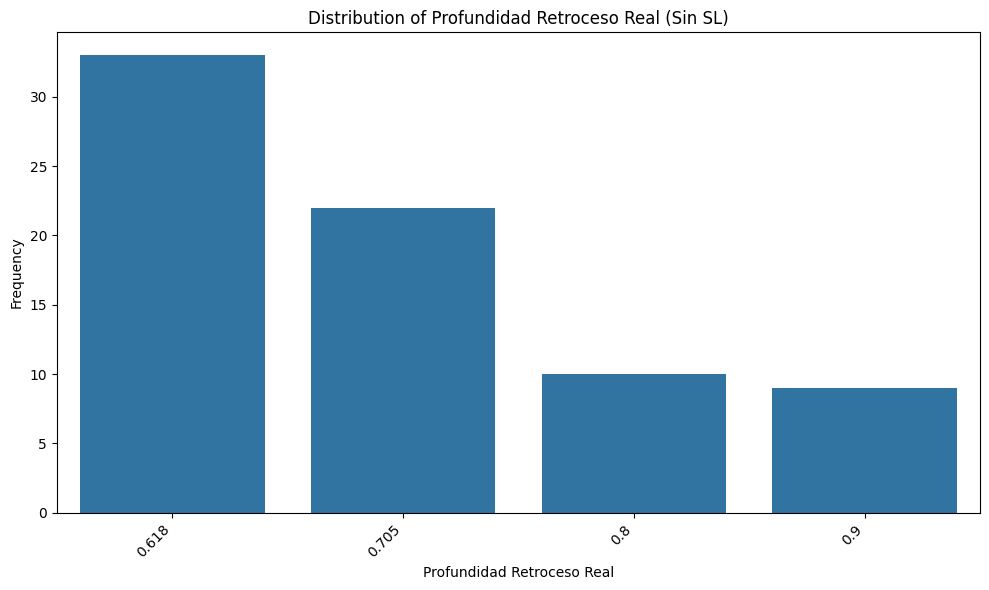

In [ ]:
# Filter out rows where 'profundidad_retroceso_real' is 1.1 from df_filtered_ote_new_tp
df_filtered_no_1_1 = df_filtered_ote_new_tp[df_filtered_ote_new_tp['profundidad_retroceso_real'] != 1.1].copy()

# Visualize the distribution of 'profundidad_retroceso_real' for the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=df_filtered_no_1_1, x='profundidad_retroceso_real', order=df_filtered_no_1_1['profundidad_retroceso_real'].value_counts().index)
plt.title('Distribution of Profundidad Retroceso Real (Sin SL)')
plt.xlabel('Profundidad Retroceso Real')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Calculate the RR ratio and add it as a new column
df_filtered_no_1_1['calculated_RR'] = df_filtered_no_1_1['ticks_TP'] / df_filtered_no_1_1['ticks_SL']

In [ ]:
# Filter out rows where 'profundidad_retroceso_real' is 0.9
df_modified = df_filtered_ote_new_tp[df_filtered_ote_new_tp['profundidad_retroceso_real'] != 0.9].copy()

# Reduce 'ticks_SL' by 10% and round up for the remaining rows
df_modified['modified_ticks_SL'] = ((df['ticks_rango_OTE'] * 0.9)*0.3334).astype(int)

# Recalculate RR with the modified SL and add to a new column 'RR_0.9'
df_modified['RR_0.9'] = df_modified['ticks_TP'] / df_modified['modified_ticks_SL']

# Display the head of the modified DataFrame and check the new columns
display(df_modified.head())

# You might also want to check the shape to see how many rows were removed
print("\nShape of the original DataFrame:", df_filtered_ote_new_tp.shape)
print("Shape of the modified DataFrame:", df_modified.shape)

,Año,mes,día,dia_semana,hora,volatilidad_ATR_14,dirección_trade,tipo_de_liquidez_tomada,antiguedad_de_liquidez,magnitud_sweep_ticks,...,TP_SD_teorico,RR_real,TP_SD_potencial,RR_potencial,resultado,fecha,intervalo_ticks_rango_OTE,ticks_rango_OTE_interval,modified_ticks_SL,RR_0.9
0,2021,9,1,3,08:00:00,1.96,-1.0,H/L,4,4,...,1.0,3.80,5.5,14.60,Take Profit,2021-09-01,"(5.951, 15.8]","(5.951, 13.0]",2,9.5
1,2021,9,1,3,09:45:00,3.22,1.0,H/L,52,8,...,0.5,2.64,0.5,2.64,Take Profit,2021-09-01,"(25.6, 35.4]","(20.0, 27.0]",8,3.625
3,2021,9,2,4,09:30:00,2.29,-1.0,Equal H/L,115,16,...,0.5,2.69,1.5,5.15,Take Profit,2021-09-02,"(25.6, 35.4]","(27.0, 34.0]",9,3.888889
6,2021,9,8,3,10:30:00,5.41,1.0,H/L,25,20,...,0.5,2.80,1.0,4.07,Take Profit,2021-09-08,"(35.4, 45.2]","(34.0, 41.0]",11,3.818182
25,2021,9,23,4,08:30:00,5.61,-1.0,H/L,4,1,...,1.5,5.11,2.0,6.33,Take Profit,2021-09-23,"(15.8, 25.6]","(20.0, 27.0]",6,7.666667



Shape of the original DataFrame: (75, 24)
Shape of the modified DataFrame: (66, 26)


In [ ]:
# Sumas totales de R:R
suma_real = df_modified['RR_real'].sum()
suma_tp_opt = df_modified['RR_0.9'].sum()

print("Suma total R:R real:", suma_real)
print("Suma total R:R con SL modificado a 0.9:", suma_tp_opt)
print("Diferencia absoluta:", suma_tp_opt - suma_real)

# Calculate the percentage difference between the total sums
# Avoid division by zero if suma_real is 0
if suma_real != 0:
    total_percentage_difference = ((suma_tp_opt - suma_real) / suma_real) * 100
    print(f"Diferencia porcentual total entre RR_0.9 y RR_real: {total_percentage_difference:.2f}%")
else:
    print("No se puede calcular la diferencia porcentual total porque la suma total de RR_real es cero.")

Suma total R:R real: 234.33999999999997
Suma total R:R con SL modificado a 0.9: 333.82973831723837
Diferencia absoluta: 99.48973831723839
Diferencia porcentual total entre RR_0.9 y RR_real: 42.46%


La respuesta es un rotundo sí, vamos a efectuar los cambios a df_main: Lo que haremos es definir como SL todas las operaciones que tuvieron retroceso a 0.9, y las TP que no tuvieron TP en 0.9 van a pasar a multiplicarse x1.33 ya que es la diferencia de RR que tiene colocando el stoploss en el 0.9.

In [ ]:
df_main['TP_optimo_con_0.9']=df_main['TP_optimo_result']
df_main['TP_optimo_con_0.9'].loc[df_main['profundidad_retroceso_real'] == 0.9] = -1
df_main['TP_optimo_con_0.9'].loc[(df_main['RR_potencial'] < df_main['tp_optimo_R']) & (df_main['TP_optimo_result'] != -1)] = 0
df_main['TP_optimo_con_0.9'].loc[df_main['TP_optimo_result'] != -1]=df_main['TP_optimo_con_0.9']*1.33


df_main['RR_real_con_0.9']=df_main['RR_real']*1.33
df_main['RR_real_con_0.9'].loc[df_main['profundidad_retroceso_real'] == 0.9] = -1
df_main['RR_real_con_0.9'].loc[df_main['RR_real'] == -1] = -1


df_main.tail(20)

,Año,mes,día,dia_semana,hora,volatilidad_ATR_14,dirección_trade,tipo_de_liquidez_tomada,antiguedad_de_liquidez,magnitud_sweep_ticks,...,RR_real,TP_SD_potencial,RR_potencial,resultado,fecha,ticks_rango_OTE_interval,tp_optimo_R,TP_optimo_result,TP_optimo_con_0.9,RR_real_con_0.9
203,2024,10,8,2,10:45:00,7.05,-1.0,Equal H/L,94,25,...,3.0,1.0,4.29,Take Profit,2024-10-08,"(34.0, 41.0]",4.0280,4.028,5.35724,3.990
204,2024,10,9,3,09:15:00,4.17,-1.0,H/L,10,16,...,-1.0,0.0,-1.00,Stoploss,2024-10-09,"(20.0, 27.0]",3.7578,-1.000,-1.00000,-1.000
205,2024,10,11,1,11:00:00,5.59,1.0,H/L + FVG,3,12,...,4.2,2.0,6.80,Take Profit,2024-10-11,"(34.0, 41.0]",4.0280,4.028,5.35724,5.586
206,2024,10,15,2,08:15:00,3.05,-1.0,H/L,6,2,...,0.0,0.5,2.80,Break Even,2024-10-15,"(5.949999999999999, 13.0]",26.4000,0.000,0.00000,0.000
207,2024,10,15,<NA>,09:15:00,3.24,-1.0,H/L + FVG,23,8,...,-1.0,0.0,-1.00,Stoploss,2024-10-15,"(13.0, 20.0]",17.7500,-1.000,-1.00000,-1.000
208,2024,10,16,3,08:15:00,3.29,1.0,H/L,2,3,...,-1.0,0.0,-1.00,Stoploss,2024-10-16,"(5.949999999999999, 13.0]",26.4000,-1.000,-1.00000,-1.000
209,2024,10,16,3,09:45:00,4.08,1.0,H/L,62,2,...,6.5,6.5,17.75,Take Profit,2024-10-16,"(13.0, 20.0]",17.7500,17.750,23.60750,8.645
210,2024,10,17,4,10:15:00,7.80,1.0,H/L,2,17,...,-1.0,0.0,-1.00,Stoploss,2024-10-17,"(48.0, 55.0]",12.6689,-1.000,-1.00000,-1.000
211,2024,10,18,5,08:45:00,3.02,-1.0,Equal H/L,5,5,...,-1.0,0.0,-1.00,Stoploss,2024-10-18,"(5.949999999999999, 13.0]",26.4000,-1.000,-1.00000,-1.000
212,2024,10,18,5,10:00:00,5.04,1.0,H/L,27,3,...,-1.0,0.0,-1.00,Stoploss,2024-10-18,"(34.0, 41.0]",4.0280,-1.000,-1.00000,-1.000


In [ ]:
df_main_retroceso_0_9 = df_main[df_main['profundidad_retroceso_real'] == 0.9].copy()
display(df_main_retroceso_0_9)

,Año,mes,día,dia_semana,hora,volatilidad_ATR_14,dirección_trade,tipo_de_liquidez_tomada,antiguedad_de_liquidez,magnitud_sweep_ticks,...,RR_real,TP_SD_potencial,RR_potencial,resultado,fecha,ticks_rango_OTE_interval,tp_optimo_R,TP_optimo_result,TP_optimo_con_0.9,RR_real_con_0.9
7,2021,9,9,4,09:00:00,4.21,-1.0,H/L,3,4,...,2.00,1.0,3.00,Take Profit,2021-09-09,"(5.949999999999999, 13.0]",26.4000,0.0000,0.00,-1.0
45,2021,10,21,4,08:00:00,2.75,1.0,Equal H/L,4,4,...,4.00,10.5,27.75,Take Profit,2021-10-21,"(5.949999999999999, 13.0]",26.4000,26.4000,-1.33,-1.0
64,2022,9,7,3,08:30:00,7.02,1.0,H/L,2,21,...,2.87,8.5,22.40,Take Profit,2022-09-07,"(34.0, 41.0]",4.0280,4.0280,-1.33,-1.0
71,2022,9,19,1,10:45:00,10.06,-1.0,Equal H/L,56,18,...,5.25,1.5,5.25,Take Profit,2022-09-19,"(48.0, 55.0]",12.6689,0.0000,0.00,-1.0
89,2022,10,19,3,08:45:00,10.06,1.0,H/L,67,6,...,4.22,1.5,5.56,Take Profit,2022-10-19,"(41.0, 48.0]",3.8338,3.8338,-1.33,-1.0
103,2023,9,11,1,11:15:00,5.56,1.0,H/L + FVG,38,5,...,2.77,1.5,5.31,Take Profit,2023-09-11,"(27.0, 34.0]",16.3155,0.0000,0.00,-1.0
110,2023,9,20,3,09:15:00,3.02,-1.0,Equal H/L,99,1,...,4.14,2.0,7.83,Take Profit,2023-09-20,"(13.0, 20.0]",17.7500,0.0000,0.00,-1.0
117,2023,9,25,1,10:00:00,6.81,-1.0,H/L + FVG,14,7,...,2.94,0.5,2.94,Take Profit,2023-09-25,"(41.0, 48.0]",3.8338,0.0000,0.00,-1.0
194,2024,9,27,5,10:30:00,5.64,-1.0,H/L,6,18,...,4.00,3.5,10.25,Take Profit,2024-09-27,"(27.0, 34.0]",16.3155,0.0000,0.00,-1.0


In [ ]:
print(df_main['TP_optimo_result'].sum())
print(df_main['TP_optimo_con_0.9'].sum())
print(df_main['RR_real'].sum())
print(df_main['RR_real_con_0.9'].sum())

236.57370000000003
311.614827
126.53
163.00220000000002


# Metricas de variantes para el modelo


=== Métricas por criterio ===
         Criterio  Win Rate (sin BEs) %  Promedio RR (ganadoras)  Profit Factor  Máx. racha de pérdidas  Trades  Wins  Losses  BEs
 TP_optimo_result                 22.53                   9.2091       2.677828                      13     223    41     141   41
TP_optimo_con_0.9                 20.88                  12.0159       3.149216                      13     223    38     144   41
  RR_real_con_0.9                 30.23                   4.8154       2.086681                      15     223    65     150    8
          RR_real                 34.42                   3.6153       1.897376                      13     223    74     141    8


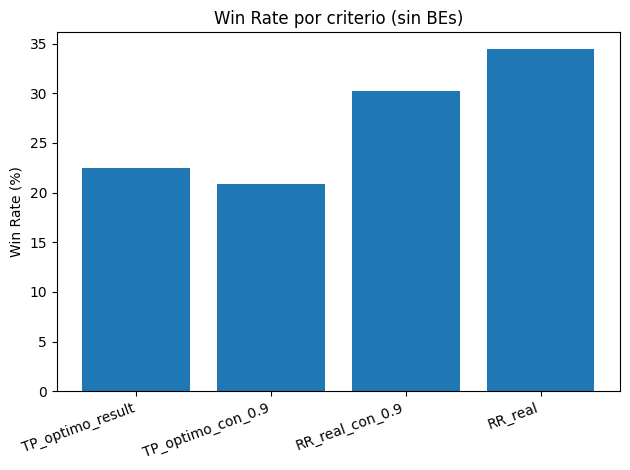

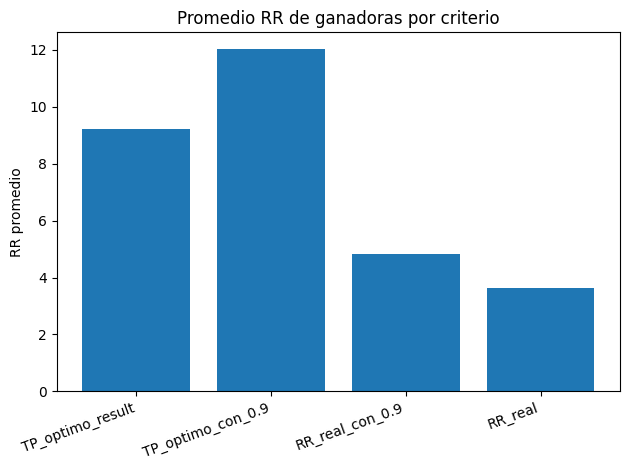

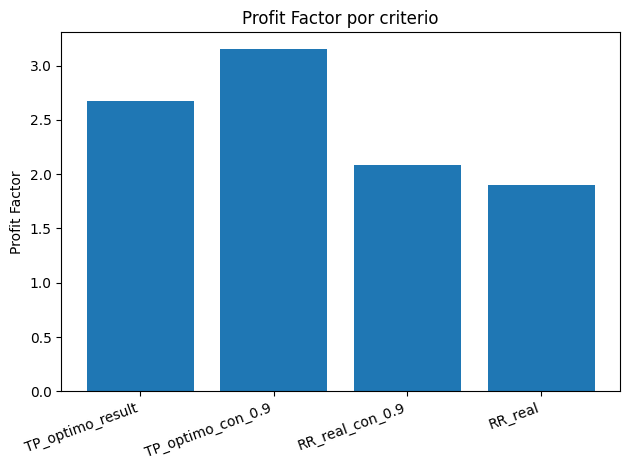

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Helpers ---
def find_col(df, names):
    m = {c.lower(): c for c in df.columns}
    for n in names:
        if n.lower() in m:
            return m[n.lower()]
    return None

def max_losing_streak(loss_bool_iterable):
    max_streak, current = 0, 0
    for is_loss in loss_bool_iterable:
        if bool(is_loss):
            current += 1
            max_streak = max(max_streak, current)
        else:
            current = 0
    return max_streak

def profit_factor(series: pd.Series) -> float:
    s = pd.to_numeric(series, errors="coerce").dropna()
    sum_pos = s[s > 0].sum()
    sum_neg = s[s < 0].sum()  # negativo o 0
    if sum_neg == 0 and sum_pos > 0:
        return np.inf
    if sum_pos == 0 and sum_neg < 0:
        return 0.0
    if sum_pos == 0 and sum_neg == 0:
        return np.nan
    return float(sum_pos / abs(sum_neg))

# --- Columnas (tolerante a mayúsc/minúsc) ---
col_tp_opt     = find_col(df_main, ["TP_optimo_result", "TP_optimo_resultado"])
col_tp_opt_09  = find_col(df_main, ["TP_optimo_con_0.9", "TP_optimo_con_09", "TP_optimo_0.9"])
col_rr_real_09 = find_col(df_main, ["RR_real_con_0.9", "RR_real_con_09", "RR_real_0.9"])
col_rr_real    = find_col(df_main, ["RR_real"])

criterios = []
if col_tp_opt is not None:    criterios.append(("TP_optimo_result", col_tp_opt))
if col_tp_opt_09 is not None: criterios.append(("TP_optimo_con_0.9", col_tp_opt_09))
if col_rr_real_09 is not None: criterios.append(("RR_real_con_0.9", col_rr_real_09))
if col_rr_real is not None:   criterios.append(("RR_real", col_rr_real))

if not criterios:
    raise ValueError("No se encontraron columnas de criterio válidas en df_main.")

# --- Cálculo por criterio ---
rows = []
for nombre, col in criterios:
    serie = pd.to_numeric(df_main[col], errors="coerce")

    wins   = serie > 0
    losses = serie < 0
    bes    = serie == 0

    denom = (wins | losses).sum()
    winrate = (wins.sum() / denom) if denom > 0 else np.nan

    avg_rr_wins = serie[wins].mean()
    max_ls = max_losing_streak(losses.astype(bool))
    pf = profit_factor(serie)

    rows.append({
        "Criterio": nombre,
        "Win Rate (sin BEs) %": round(winrate * 100, 2) if pd.notna(winrate) else np.nan,
        "Promedio RR (ganadoras)": round(avg_rr_wins, 4) if pd.notna(avg_rr_wins) else np.nan,
        "Profit Factor": (float(pf) if pd.notna(pf) and not np.isinf(pf) else (np.inf if np.isinf(pf) else np.nan)),
        "Máx. racha de pérdidas": int(max_ls),
        "Trades": int(serie.notna().sum()),
        "Wins": int(wins.sum()),
        "Losses": int(losses.sum()),
        "BEs": int(bes.sum()),
    })

summary = pd.DataFrame(rows, columns=[
    "Criterio", "Win Rate (sin BEs) %", "Promedio RR (ganadoras)",
    "Profit Factor", "Máx. racha de pérdidas", "Trades", "Wins", "Losses", "BEs"
])

print("\n=== Métricas por criterio ===")
print(summary.to_string(index=False))

# --- Gráficos (opcionales) ---
# Win Rate
plt.figure()
plt.bar(summary["Criterio"], summary["Win Rate (sin BEs) %"])
plt.title("Win Rate por criterio (sin BEs)")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Promedio RR
plt.figure()
plt.bar(summary["Criterio"], summary["Promedio RR (ganadoras)"])
plt.title("Promedio RR de ganadoras por criterio")
plt.ylabel("RR promedio")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

# Profit Factor
plt.figure()
# Reemplazo inf por NaN para graficar y evitar desbordes
pf_plot = summary["Profit Factor"].replace([np.inf, -np.inf], np.nan)
plt.bar(summary["Criterio"], pf_plot)
plt.title("Profit Factor por criterio")
plt.ylabel("Profit Factor")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
df.columns

Index(['Año', 'mes', 'día', 'dia_semana', 'hora', 'volatilidad_ATR_14',
       'dirección_trade', 'tipo_de_liquidez_tomada', 'antiguedad_de_liquidez',
       'magnitud_sweep_ticks', 'num_velas_confirmación', 'ticks_rango_OTE',
       'nivel_retroceso_OTE', 'profundidad_retroceso_real', 'ticks_SL',
       'ticks_TP', 'TP_SD_teorico', 'RR_real', 'TP_SD_potencial',
       'RR_potencial', 'resultado', 'fecha'],
      dtype='object')

## ML models


### Preprocesamiento para Modelos de Machine Learning

In [ ]:
# Drop 'spoiler' features that reveal the result of the trade
spoiler_features = ['profundidad_retroceso_real', 'TP_SD_teorico', 'RR_real', 'TP_SD_potencial', 'RR_potencial','nivel_retroceso_OTE']
df_ml = df.drop(columns=spoiler_features + ['fecha']) # Also drop the datetime column as it's not needed for the model

# Drop rows where the target variable 'resultado' is not TP or SL
df_ml = df_ml[df_ml['resultado'].isin(['Take Profit', 'Stoploss'])].copy()

# Define features (X) and target (y)
X = df_ml.drop(columns=['resultado'])
y = df_ml['resultado'].apply(lambda x: 1 if x == 'Take Profit' else 0) # Convert target to numerical (1 for TP, 0 for SL)

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
numerical_features = X.select_dtypes(include=np.number).columns

# Display the first few rows of features and target
print("Features (X) head:")
display(X.head())
print("\nTarget (y) head:")
display(y.head())

Features (X) head:


,Año,mes,día,dia_semana,hora,volatilidad_ATR_14,dirección_trade,tipo_de_liquidez_tomada,antiguedad_de_liquidez,magnitud_sweep_ticks,num_velas_confirmación,ticks_rango_OTE,ticks_SL,ticks_TP
0,2021,9,1,3,08:00:00,1.96,-1.0,H/L,4,4,1,8,5,19
1,2021,9,1,3,09:45:00,3.22,1.0,H/L,52,8,1,27,11,29
2,2021,9,2,4,09:00:00,1.99,-1.0,H/L,74,2,0,11,4,12
3,2021,9,2,4,09:30:00,2.29,-1.0,Equal H/L,115,16,1,32,13,35
4,2021,9,7,2,10:00:00,3.98,1.0,Equal H/L,313,21,2,23,9,48



Target (y) head:


,resultado
0,1
1,1
2,0
3,1
4,0


### Separación de datos y Manejo de Desbalance

In [ ]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify categorical and numerical features (re-identified in case of changes)
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

# Create an imputer for numerical features
imputer = SimpleImputer(strategy='median') # Using median as it's less sensitive to outliers

# Apply imputer to numerical features in the training data
X_train_numerical_imputed = imputer.fit_transform(X_train[numerical_features])

# Convert the imputed array back to a DataFrame to maintain column names
X_train_numerical_imputed_df = pd.DataFrame(X_train_numerical_imputed, columns=numerical_features, index=X_train.index)

# Apply SMOTE to the imputed numerical training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_numerical_imputed_df, y_train)

# We'll handle categorical features separately in the next step (preprocessing pipeline)

print("Shape of original training data:", X_train.shape)
print("Shape of resampled training data (numerical only, after imputation):", X_train_res.shape)
print("\nClass distribution in original training data:")
display(y_train.value_counts(normalize=True))
print("\nClass distribution in resampled training data:")
display(y_train_res.value_counts(normalize=True))

Shape of original training data: (233, 14)
Shape of resampled training data (numerical only, after imputation): (318, 12)

Class distribution in original training data:


,proportion
resultado,
0,0.682403
1,0.317597



Class distribution in resampled training data:


,proportion
resultado,
1,0.5
0,0.5


### Preprocesamiento de Features (Pipeline)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Handle unknown categories by ignoring them

# Create a column transformer to apply different transformations to different columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Display the preprocessor (optional)
display(preprocessor)

# Note: The actual transformation will be applied within the model pipeline later.
# This preprocessor is now ready to be included in a full machine learning pipeline.

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['Año', 'mes', 'día', 'dia_semana', 'volatilidad_ATR_14',
       'dirección_trade', 'antiguedad_de_liquidez', 'magnitud_sweep_ticks',
       'num_velas_confirmación', 'ticks_rango_OTE', 'ticks_SL', 'ticks_TP'],
      dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['hora', 'tipo_de_liquidez_tomada'], dtype='object'))])

A continuacion entrenaremios modelos de ML, Naive Bayes mejoro el win rate del modelo un 7%! Eso es una mejora significativa ya que tiene un recall para take profits de 0.95, lo que quiere decir que no se pierde casi ningún TP

### Entrenamiento y Evaluación de Modelos de Machine Learning

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb # Import LightGBM
import xgboost as xgb # Import XGBoost


from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer # Import SimpleImputer

# Define a list of models to train
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('SVM', SVC(probability=True, random_state=42)), # probability=True is needed for roc_curve
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Naive Bayes', GaussianNB()),
    ('MLP Classifier', MLPClassifier(random_state=42)),
    ('LightGBM', lgb.LGBMClassifier(random_state=42)), # Add LightGBM
    ('XGBoost', xgb.XGBClassifier(random_state=42)) # Add XGBoost
]

# Dictionary to store evaluation results
results = {}

# Train and evaluate each model
for name, model in models:
    print(f"Training {name}...")

    # Create preprocessing pipelines for numerical and categorical features
    # Include Imputer in the numerical pipeline
    numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')), # Impute missing values
                                           ('scaler', StandardScaler())])
    categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Handle unknown categories by ignoring them

    # Update the column transformer to use the new numerical pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)])


    # Create a pipeline with preprocessing and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the pipeline on the original training data (before SMOTE)
    # SMOTE will be applied later if needed, but the pipeline itself should handle
    # preprocessing of the original data structure.
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1] # Get probabilities for AUC

    # Evaluate the model
    roc_auc = roc_curve(y_test, y_prob) # Calculate ROC curve
    auc_score = auc(roc_auc[0], roc_auc[1]) # Calculate AUC

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    results[name] = {
        'AUC': auc_score,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }

    print(f"{name} - AUC: {auc_score:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

# Create a comparison table
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='AUC', ascending=False)

print("\n### Model Comparison Table")
display(results_df)

Training Logistic Regression...
Logistic Regression - AUC: 0.6039, Accuracy: 0.6610, Precision: 0.4000, Recall: 0.1053, F1-Score: 0.1667
Training Random Forest...
Random Forest - AUC: 0.4868, Accuracy: 0.6610, Precision: 0.3333, Recall: 0.0526, F1-Score: 0.0909
Training Gradient Boosting...
Gradient Boosting - AUC: 0.4000, Accuracy: 0.5932, Precision: 0.1429, Recall: 0.0526, F1-Score: 0.0769
Training SVM...
SVM - AUC: 0.5368, Accuracy: 0.6949, Precision: 1.0000, Recall: 0.0526, F1-Score: 0.1000
Training K-Nearest Neighbors...
K-Nearest Neighbors - AUC: 0.4928, Accuracy: 0.5254, Precision: 0.0909, Recall: 0.0526, F1-Score: 0.0667
Training Decision Tree...
Decision Tree - AUC: 0.5618, Accuracy: 0.5932, Precision: 0.3913, Recall: 0.4737, F1-Score: 0.4286
Training Naive Bayes...
Naive Bayes - AUC: 0.7039, Accuracy: 0.4068, Precision: 0.3462, Recall: 0.9474, F1-Score: 0.5070
Training MLP Classifier...
MLP Classifier - AUC: 0.6250, Accuracy: 0.6271, Precision: 0.3333, Recall: 0.1579, F1-Scor

,AUC,Accuracy,Precision,Recall,F1-Score
Naive Bayes,0.703947,0.406780,0.346154,0.947368,0.507042
MLP Classifier,0.625000,0.627119,0.333333,0.157895,0.214286
Logistic Regression,0.603947,0.661017,0.400000,0.105263,0.166667
Decision Tree,0.561842,0.593220,0.391304,0.473684,0.428571
SVM,0.536842,0.694915,1.000000,0.052632,0.100000
K-Nearest Neighbors,0.492763,0.525424,0.090909,0.052632,0.066667
Random Forest,0.486842,0.661017,0.333333,0.052632,0.090909
XGBoost,0.406579,0.610169,0.357143,0.263158,0.303030
Gradient Boosting,0.400000,0.593220,0.142857,0.052632,0.076923
LightGBM,0.373684,0.542373,0.166667,0.105263,0.129032


### Gridsearch de NB

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define preprocessing pipeline (same as before)
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])


# Define parameter grids for each model
# Naive Bayes has fewer hyperparameters to tune
nb_param_grid = {
    'classifier__var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
}

models_to_tune = [
    ('Naive Bayes', GaussianNB(), nb_param_grid),
    # ('Decision Tree', DecisionTreeClassifier(random_state=42), dt_param_grid),
    # ('XGBoost', xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), xgb_param_grid) # Add eval_metric to suppress warning
]

tuned_models = {}

for name, model, param_grid in models_to_tune:
    print(f"Performing Grid Search for {name}...")

    # Create a pipeline with preprocessing and the current model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1) # Optimize for F1-score
    grid_search.fit(X_train, y_train) # Fit on the original training data

    tuned_models[name] = grid_search

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best F1-score for {name}: {grid_search.best_score_:.4f}")
    print("-" * 30)

Performing Grid Search for Naive Bayes...
Best parameters for Naive Bayes: {'classifier__var_smoothing': 0.001}
Best F1-score for Naive Bayes: 0.5162
------------------------------


Retraining Naive Bayes with optimal parameters...

### Detailed Evaluation Metrics for Tuned Naive Bayes Model
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.35      0.51        40
           1       0.41      0.95      0.57        19

    accuracy                           0.54        59
   macro avg       0.67      0.65      0.54        59
weighted avg       0.76      0.54      0.53        59


Confusion Matrix:


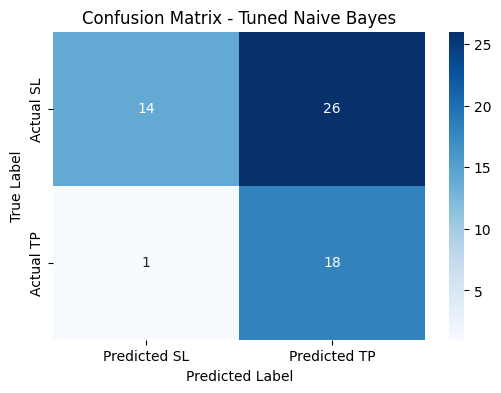


### Predicted vs Actual Table (Tuned Naive Bayes)


,Actual,Predicted
188,0,1
212,0,1
75,0,0
71,0,1
258,0,0
281,0,1
70,1,1
80,0,0
140,1,1
88,0,1


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define preprocessing pipeline (same as before)
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                       ('scaler', StandardScaler())])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

# Get the best parameters for Naive Bayes from the Grid Search results
best_params_nb = tuned_models['Naive Bayes'].best_params_

# Extract the actual classifier parameters
nb_classifier_params = {key.replace('classifier__', ''): value for key, value in best_params_nb.items()}

# Retrain Naive Bayes with the best parameters in a pipeline
tuned_nb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', GaussianNB(**nb_classifier_params))])

print("Retraining Naive Bayes with optimal parameters...")
tuned_nb_pipeline.fit(X_train, y_train) # Train on original training data

# Evaluate the retrained model on the test set
y_pred_nb_tuned = tuned_nb_pipeline.predict(X_test)
y_prob_nb_tuned = tuned_nb_pipeline.predict_proba(X_test)[:, 1]

# --- Detailed Metrics ---
print("\n### Detailed Evaluation Metrics for Tuned Naive Bayes Model")
print("Classification Report:")
print(classification_report(y_test, y_pred_nb_tuned))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_nb_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted SL', 'Predicted TP'], yticklabels=['Actual SL', 'Actual TP'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Tuned Naive Bayes')
plt.show()

# --- Predicted vs Actual Table ---
print("\n### Predicted vs Actual Table (Tuned Naive Bayes)")
predictions_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_nb_tuned})
display(predictions_df.head(30))


In [ ]:
# Calculate the original win rate (from the original df, considering only TP and SL)
df_real_results = df[df['resultado'].isin(['Take Profit', 'Stoploss'])].copy()
total_real_trades = len(df_real_results)
real_take_profit_trades = (df_real_results['resultado'] == 'Take Profit').sum()
real_win_rate = (real_take_profit_trades / total_real_trades) * 100 if total_real_trades > 0 else 0

print(f"Original Win Rate: {real_win_rate:.2f}%")

# Calculate the win rate based on the tuned Naive Bayes model's predictions on the test set
# We need to consider only the trades where the model predicted 'Take Profit' (1)
# and see how many of those were actually 'Take Profit' (1)
# Note: This is more about precision of the positive prediction than a traditional win rate
# Let's calculate a win rate based on trades where the model predicted TP and the actual result was TP, divided by all trades where the model predicted TP.
predicted_tp_trades = predictions_df[predictions_df['Predicted'] == 1]
correctly_predicted_tp = predicted_tp_trades[predicted_tp_trades['Actual'] == 1].shape[0]
total_predicted_tp = predicted_tp_trades.shape[0]

predicted_win_rate_precision = (correctly_predicted_tp / total_predicted_tp) * 100 if total_predicted_tp > 0 else 0

print(f"Win Rate based on Tuned Naive Bayes Model Predictions (Precision for TP): {predicted_win_rate_precision:.2f}%")

# Alternatively, we can calculate the overall accuracy of the model's prediction (TP and SL)
overall_prediction_accuracy = accuracy_score(predictions_df['Actual'], predictions_df['Predicted']) * 100
print(f"Overall Prediction Accuracy of Tuned Naive Bayes Model: {overall_prediction_accuracy:.2f}%")

Original Win Rate: 31.85%
Win Rate based on Tuned Naive Bayes Model Predictions (Precision for TP): 40.91%
Overall Prediction Accuracy of Tuned Naive Bayes Model: 54.24%


### Predicción con Datos Manuales usando el Modelo Entrenado

In [ ]:
new_trade_data = {
    'Año': [2021],
    'mes': [10],
    'día': [27],
    'dia_semana': [3], # 1=Lunes, 2=Martes, 3=Miércoles, 4=Jueves, 5=Viernes
    'hora': ['09:15:00'],
    'volatilidad_ATR_14': [3.64],
    'dirección_trade': [-1], # 1 for long, -1 for short
    'tipo_de_liquidez_tomada': ['H/L'], # Example: 'H/L', 'Equal H/L', 'H/L + FVG', etc.
    'antiguedad_de_liquidez': [3],
    'magnitud_sweep_ticks': [1],
    'num_velas_confirmación': [0],
    'ticks_rango_OTE': [13],
    'ticks_SL': [5],
    'ticks_TP': [21],
}

feature_columns = X.columns

new_trade_df = pd.DataFrame(new_trade_data, columns=feature_columns)

predicted_probability = tuned_nb_pipeline.predict_proba(new_trade_df)[:, 1] # Probability of Take Profit
predicted_class = tuned_nb_pipeline.predict(new_trade_df)[0] # Predicted class (0 or 1)

print(f"\nPredicted probability of Take Profit: {predicted_probability[0]:.4f}")

# Interpret the predicted class
if predicted_class == 1:
    print("Predicted Outcome: Take Profit")
else:
    print("Predicted Outcome: Stoploss")

# You can also set a threshold for the probability to make a decision
probability_threshold = 0.5 # Example threshold
if predicted_probability[0] >= probability_threshold:
    print(f"Decision (using threshold {probability_threshold}): Consider taking the trade.")
else:
    print(f"Decision (using threshold {probability_threshold}): Consider avoiding the trade.")


Predicted probability of Take Profit: 0.9996
Predicted Outcome: Take Profit
Decision (using threshold 0.5): Consider taking the trade.


# Modelo regrsion para RR potencial


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
import lightgbm as lgb # Import LightGBM
import xgboost as xgb # Import XGBoost

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Filter data to include only 'Take Profit' trades as requested
df_regression = df_filtered_ote_new[df_filtered_ote_new['resultado'] == 'Take Profit'].copy()

# Define features (X) and target (y) for regression
# Use the same features as the classification task (X), dropping the target and spoiler features
spoiler_features = ['profundidad_retroceso_real', 'TP_SD_teorico', 'RR_real', 'TP_SD_potencial', 'RR_potencial','nivel_retroceso_OTE']
# Ensure 'resultado' is dropped if it's still in X from the classification task
features_for_regression = [col for col in X.columns if col not in spoiler_features + ['resultado']]

X_reg = df_regression[features_for_regression]
y_reg = df_regression['RR_potencial'] # Target is RR_potencial

# Identify categorical and numerical features for regression (based on X_reg)
categorical_features_reg = X_reg.select_dtypes(include=['object', 'category']).columns
numerical_features_reg = X_reg.select_dtypes(include=np.number).columns

# Split data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Define preprocessing pipeline for regression (similar to classification but for regression features)
numerical_transformer_reg = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                           ('scaler', StandardScaler())])
categorical_transformer_reg = OneHotEncoder(handle_unknown='ignore')

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_reg, numerical_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)])

# Define a list of regression models to train
regression_models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest Regressor', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(random_state=42)),
    ('SVM Regressor', SVR()),
    ('K-Nearest Neighbors Regressor', KNeighborsRegressor()),
    ('Decision Tree Regressor', DecisionTreeRegressor(random_state=42)),
    ('MLP Regressor', MLPRegressor(random_state=42, max_iter=1000)), # Increased max_iter for convergence
    ('LightGBM Regressor', lgb.LGBMRegressor(random_state=42)), # Add LightGBM
    ('XGBoost Regressor', xgb.XGBRegressor(random_state=42)) # Add XGBoost
]

# Dictionary to store evaluation results for regression
regression_results = {}

# Train and evaluate each regression model
for name, model in regression_models:
    print(f"Training {name}...")

    # Create a pipeline with preprocessing and the regression model
    pipeline_reg = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                   ('regressor', model)])

    # Train the pipeline
    pipeline_reg.fit(X_train_reg, y_train_reg)

    # Make predictions on the test set
    y_pred_reg = pipeline_reg.predict(X_test_reg)

    # Evaluate the model
    mse = mean_squared_error(y_test_reg, y_pred_reg)
    rmse = np.sqrt(mse) # Calculate Root Mean Squared Error
    mae = mean_absolute_error(y_test_reg, y_pred_reg)
    r2 = r2_score(y_test_reg, y_pred_reg)

    regression_results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2-Score': r2
    }

    print(f"{name} - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2-Score: {r2:.4f}")

# Create a comparison table for regression models
regression_results_df = pd.DataFrame(regression_results).T
# Sort by a relevant metric, e.g., R2-Score (higher is better) or RMSE (lower is better)
regression_results_df = regression_results_df.sort_values(by='R2-Score', ascending=False)

print("\n### Regression Model Comparison Table (Predicting RR_potencial)")
display(regression_results_df)

Training Linear Regression...
Linear Regression - MSE: 96.3649, RMSE: 9.8166, MAE: 7.9052, R2-Score: -0.0664
Training Random Forest Regressor...
Random Forest Regressor - MSE: 95.2757, RMSE: 9.7609, MAE: 8.2147, R2-Score: -0.0543
Training Gradient Boosting Regressor...
Gradient Boosting Regressor - MSE: 103.8284, RMSE: 10.1896, MAE: 8.2906, R2-Score: -0.1490
Training SVM Regressor...
SVM Regressor - MSE: 156.9056, RMSE: 12.5262, MAE: 9.0857, R2-Score: -0.7364
Training K-Nearest Neighbors Regressor...
K-Nearest Neighbors Regressor - MSE: 116.0994, RMSE: 10.7749, MAE: 9.0749, R2-Score: -0.2848
Training Decision Tree Regressor...
Decision Tree Regressor - MSE: 103.6332, RMSE: 10.1800, MAE: 8.2253, R2-Score: -0.1468
Training MLP Regressor...
MLP Regressor - MSE: 103.2432, RMSE: 10.1609, MAE: 8.7197, R2-Score: -0.1425
Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_col_wise=true` to rem

,MSE,RMSE,MAE,R2-Score
XGBoost Regressor,93.159143,9.651898,7.591595,-0.030923
Random Forest Regressor,95.275747,9.760930,8.214747,-0.054346
Linear Regression,96.364887,9.816562,7.905226,-0.066399
MLP Regressor,103.243226,10.160867,8.719720,-0.142516
Decision Tree Regressor,103.633227,10.180041,8.225333,-0.146832
Gradient Boosting Regressor,103.828449,10.189625,8.290637,-0.148992
LightGBM Regressor,109.763943,10.476829,7.803857,-0.214676
K-Nearest Neighbors Regressor,116.099370,10.774942,9.074933,-0.284786
SVM Regressor,156.905634,12.526198,9.085688,-0.736358


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define preprocessing pipeline (same as before for regression)
numerical_transformer_reg = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                           ('scaler', StandardScaler())])
categorical_transformer_reg = OneHotEncoder(handle_unknown='ignore')

preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer_reg, numerical_features_reg),
        ('cat', categorical_transformer_reg, categorical_features_reg)])

# Define the parameter grid for XGBoost Regressor
# This is a starting point, you might need to adjust the values and parameters
xgb_param_grid = {
    'regressor__n_estimators': [50, 100, 200], # Number of boosting rounds
    'regressor__learning_rate': [0.01, 0.1, 0.2], # Step size shrinkage
    'regressor__max_depth': [3, 5, 7], # Maximum depth of a tree
    'regressor__subsample': [0.7, 0.9, 1.0], # Subsample ratio of the training instance
    'regressor__colsample_bytree': [0.7, 0.9, 1.0], # Subsample ratio of columns when constructing each tree
}

# Create a pipeline with preprocessing and the XGBoost Regressor model
pipeline_xgb_reg = Pipeline(steps=[('preprocessor', preprocessor_reg),
                                   ('regressor', xgb.XGBRegressor(random_state=42))])

# Perform Grid Search
print("Performing Grid Search for XGBoost Regressor to minimize MAE...")
grid_search_xgb_reg = GridSearchCV(pipeline_xgb_reg, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1) # Use neg_mean_absolute_error for minimizing MAE
grid_search_xgb_reg.fit(X_train_reg, y_train_reg) # Fit on the training data for regression

print("\nBest parameters for XGBoost Regressor:", grid_search_xgb_reg.best_params_)
print(f"Best MAE (from cross-validation): {-grid_search_xgb_reg.best_score_:.4f}") # Corrected f-string syntax

# You can access the best model like this:
# best_xgb_reg_model = grid_search_xgb_reg.best_estimator_

# Evaluate the best model on the test set
# y_pred_xgb_tuned = grid_search_xgb_reg.predict(X_test_reg)
# mse_tuned = mean_squared_error(y_test_reg, y_pred_xgb_tuned)
# rmse_tuned = np.sqrt(mse_tuned)
# mae_tuned = mean_absolute_error(y_test_reg, y_pred_xgb_tuned)
# r2_tuned = r2_score(y_test_reg, y_pred_xgb_tuned)

# print(f"\nTuned XGBoost Regressor - MSE: {mse_tuned:.4f}, RMSE: {rmse_tuned:.4f}, MAE: {mae_tuned:.4f}, R2-Score: {r2_tuned:.4f}")

Performing Grid Search for XGBoost Regressor to minimize MAE...

Best parameters for XGBoost Regressor: {'regressor__colsample_bytree': 0.7, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 200, 'regressor__subsample': 0.7}
Best MAE (from cross-validation): 6.7042
